In [1]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### Function of ET by AAyoub. 

In [1]:
import pandas as pd
import numpy as np
from math import pi, cos, sin, acos, exp, log, sqrt, tan


def ETref(df, lat, elevation):
    """
    This function takes a DataFrame and adds various calculated columns
    for meteorological and agricultural research.
    """
    # Julian Date (day)
    ###
    # Julian Date represents the number of days since January 1st of each year.
    df['Julian Date (day)'] = (
        df['Date'] - pd.to_datetime(df['Date'].dt.year.astype(str) + '-01-01')).dt.days + 1

    # U2 (Wind Speed at 2m) in meters per second (m/s)
    # Formula: U2 = U3 * (4.87 / ln(67.8 * 3 - 5.42))
    df['U2 (m/s)'] = df['U3_m_s-1'] * (4.87 / np.log(67.8 * 10 - 5.42))#because windspeed gems height is at 10m

    # Rs (Solar Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rs = G * 0.0864
    df['Rs (MJ/m²/day)'] = df['Rs_W_m2'] * 0.0864

    # # Rhmax_adj (Adjusted Max Relative Humidity) in percentage (%)
    # # Formula: Rhmax_adj = min(Rh_max, 100)
    # df['Rhmax_adj (%)'] = np.minimum(df['Rhmax_%'], 100)

    # # Rh_avg (Average Relative Humidity) in percentage (%)
    # # Formula: Rh_avg = (Rh_min + Rhmax_adj) / 2
    # df['Rh_avg (%)'] = (df['Rhmin_%'] + df['Rhmax_adj (%)']) / 2

    # Tavg (Average Temperature) in degrees Celsius (°C)
    # Formula: Tavg = (Tmin + Tmax) / 2
    df['Tavg (°C)'] = (df['Tmax_C'] + df['Tmin_C']) / 2
    df['Tavg (°C)'] = pd.to_numeric(df['Tavg (°C)'], errors='raise')

    # Lambda (λ) in MegaJoules per kilogram (MJ/kg)
    # Formula: Lambda = 2.501 - (2.361e-3 * Tavg)
    df['Lambda (MJ/kg)'] = 2.501 - (2.361e-3 * df['Tavg (°C)'])

    # P (Atmospheric Pressure) in kiloPascals (kPa)
    # Formula: P = 101.3 * ((293 - 0.0065 * 552) / 293)^5.26
    df['P (kPa)'] = 101.3 * ((293 - 0.0065 * elevation) / 293)**5.26  # correct

    # Gamma (ϒ) in kiloPascals per degree Celsius (kPa/°C)
    # Formula: Gamma = (1.013 * P) / (0.622 * Lambda) * 1e-3
    df['Gamma (kPa/°C)'] = ((1.013 * 1e-3 * df['P (kPa)']) /
                            (0.622 * df['Lambda (MJ/kg)']))

    # Delta (∆) in kiloPascals per degree Celsius (kPa/°C)
    # Formula: Delta = (4098 * (0.6108 * exp(17.27 * Tavg / (Tavg + 237.3)))) / (Tavg + 237.3)^2
    df['Delta (kPa/°C)'] = (4098 * (0.6108 * np.exp(17.27 * df['Tavg (°C)'] /
                                                    (df['Tavg (°C)'] + 237.3)))) / ((df['Tavg (°C)'] + 237.3)**2)

    # eᵒ(Tmax) (Saturation Vapor Pressure at Tmax) in kiloPascals (kPa)
    # Formula: eᵒ(Tmax) = 0.6108 * exp(17.27 * Tmax / (Tmax + 237.3))
    df['eᵒ(Tmax) (kPa)'] = 0.6108 * np.exp(17.27 *
                                           df['Tmax_C'] / (df['Tmax_C'] + 237.3))

    # eᵒ(Tmin) (Saturation Vapor Pressure at Tmin) in kiloPascals (kPa)
    # Formula: eᵒ(Tmin) = 0.6108 * exp(17.27 * Tmin / (Tmin + 237.3))
    df['eᵒ(Tmin) (kPa)'] = 0.6108 * np.exp(17.27 *
                                           df['Tmin_C'] / (df['Tmin_C'] + 237.3))

    # eᵒs (Average Saturation Vapor Pressure) in kiloPascals (kPa)
    # Formula: eᵒs = (eᵒ(Tmax) + eᵒ(Tmin)) / 2
    df['eᵒs (kPa)'] = (df['eᵒ(Tmax) (kPa)'] + df['eᵒ(Tmin) (kPa)']) / 2

    # eᵒa (Actual Vapor Pressure) in kiloPascals (kPa)
    # Formula: eᵒa = eᵒs * (Rh_avg / 100)
    # df['eᵒa (kPa)'] = ((df['eᵒ(Tmin) (kPa)'] * (df['Rhmax_adj (%)']/100)
    #                     ) + (df['eᵒ(Tmax) (kPa)'] * (df['Rhmin_%']/100)))/2
    df['eᵒa (kPa)']=0.6108*np.exp(17.27*df["T_dew_C"]/(df["T_dew_C"]+237.3))
    # VPD (Vapor Pressure Deficit) in kiloPascals (kPa)
    # Formula: VPD = eᵒs - eᵒa
    df['VPD (kPa)'] = df['eᵒs (kPa)'] - df['eᵒa (kPa)']

    # dr (Inverse Relative Distance Earth-Sun)
    # Formula: dr = 1 + 0.033 * cos(2π * Julian Date (day) / 365)
    df['Inverse Relative Distance Earth-Sun'] = 1 + 0.033 * \
        np.cos(2 * np.pi * df['Julian Date (day)'] / 365)

    # δ (Solar Declination) in radians (rad)
    # Formula: δ = 0.409 * sin(2π * Julian Date (day) / 365 - 1.39)
    df['Solar Declination (rad)'] = 0.409 * np.sin((2 *
                                                    np.pi * df['Julian Date (day)'] / 365) - 1.39)

    # ωs (Sunset Hour Angle) in radians (rad)
    # Formula: ωs = acos(-tan(lat) * tan(δ))
    df['Sunset Hour Angle (rad)'] = np.arccos(-np.tan(lat)
                                              * np.tan(df['Solar Declination (rad)']))

    # Ra (Extraterrestrial Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Ra = (24 * 60 / π) * Gsc * dr * (ws*sin(lat) * sin(δ) + cos(lat) * cos(δ) * sin(ωs))
    df['Ra (MJ/m²/day)'] = (24 * 60 / np.pi) * 0.082 * df['Inverse Relative Distance Earth-Sun'] * (df['Sunset Hour Angle (rad)']*np.sin(lat)
                                                                                                    * np.sin(df['Solar Declination (rad)']) + (np.cos(lat) * np.cos(df['Solar Declination (rad)']) * np.sin(df['Sunset Hour Angle (rad)'])))

    # Rso (Clear Sky Solar Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rso = (0.75 + 2e-5 * 552) * Ra
    df['Rso (MJ/m²/day)'] = (0.75 + 2e-5 * elevation) * df['Ra (MJ/m²/day)']

    # Rns (Net Solar Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rns = (1 - 0.23) * Rs
    df['Rns (MJ/m²/day)'] = (1 - 0.23) * \
        df['Rs (MJ/m²/day)']  # we need alfaalfa albedo

    # Rnl (Net Longwave Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rnl = (4.903e-9 * ((Tavg + 273.16)^4 + (Tmin + 273.16)^4) / 2 * (0.34 - 0.14 * sqrt(eᵒa)) * (1.35 * Rns / Rso) - 0.35)
    df['Rnl (MJ/m²/day)'] = (4.903e-9 * ((df['Tavg (°C)'] + 273.16)**4 + (df['Tmin_C'] + 273.16)**4) / 2) * (0.34 -
                                                                                                             0.14 * np.sqrt(df['eᵒa (kPa)'])) * ((1.35 * np.minimum(df['Rs (MJ/m²/day)'] / df['Rso (MJ/m²/day)'], 1) - 0.35))

    # Rn (Net Radiation) in MegaJoules per square meter per day (MJ/m²/day)
    # Formula: Rn = Rns - Rnl
    df['Rn (MJ/m²/day)'] = df['Rns (MJ/m²/day)'] - df['Rnl (MJ/m²/day)']

    # ETo (Reference Evapotranspiration) in millimeters per day (mm/day)
    # ETo (Reference Evapotranspiration) in millimeters per day (mm/day)
    #df['ETo (mm/day)'] = (0.408 * df['Delta (kPa/°C)'] * df['Rn (MJ/m²/day)'] + df['Gamma (kPa/°C)'] * (900 / (df['Tavg (°C)'] + 273))
                          #* df['U2 (m/s)'] * df['VPD (kPa)']) / (df['Delta (kPa/°C)'] + df['Gamma (kPa/°C)'] * (1 + 0.34 * df['U2 (m/s)']))
    # ETo (Reference Evapotranspiration) in inches per day (in/day)
    df['ETo (in/day)'] = (0.408 * df['Delta (kPa/°C)'] * df['Rn (MJ/m²/day)'] + df['Gamma (kPa/°C)'] * (900 / (df['Tavg (°C)'] + 273))
                          * df['U2 (m/s)'] * df['VPD (kPa)']) / (df['Delta (kPa/°C)'] + df['Gamma (kPa/°C)'] * (1 + 0.34 * df['U2 (m/s)'])) * 0.0393701

    # ETr (Reference Evapotranspiration for grass) in millimeters per day (mm/day)
   # df['ETr (mm/day)'] = (0.408 * df['Delta (kPa/°C)'] * df['Rn (MJ/m²/day)'] + df['Gamma (kPa/°C)'] * (1600 / (df['Tavg (°C)'] + 273))
                          #* df['U2 (m/s)'] * df['VPD (kPa)']) / (df['Delta (kPa/°C)'] + df['Gamma (kPa/°C)'] * (1 + 0.38 * df['U2 (m/s)']))
    # ETr (Reference Evapotranspiration for grass) in millimeters per day (in/day)
    df['ETr (in/day)'] = (0.408 * df['Delta (kPa/°C)'] * df['Rn (MJ/m²/day)'] + df['Gamma (kPa/°C)'] * (1600 / (df['Tavg (°C)'] + 273))
                          * df['U2 (m/s)'] * df['VPD (kPa)']) / (df['Delta (kPa/°C)'] + df['Gamma (kPa/°C)'] * (1 + 0.38 * df['U2 (m/s)'])) * 0.0393701

    return df



### Becker and Sherbourne 2022 and 2023

In [2]:

# Load the CSV file
df_GEMS_Sherbourne2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_sherbourne_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Sherbourne2022['Date'] = pd.to_datetime(df_GEMS_Sherbourne2022['Date'])

#Rename columns if necessary
df_GEMS_Sherbourne2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define  latitude and elevation
latitude = 0.792 #  latitude of the location in radian
elevation = 287  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Sherbourne2022 = ETref(df_GEMS_Sherbourne2022, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Sherbourne2022.head)



<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4738   -22.2  67   987      342 2022-01-01   
1             1      1   4753   -17.2  70   988      344 2022-01-02   
2             2      2   4770    -4.4  74   983      345 2022-01-03   
3             3      3   4787    -2.2  81   968      347 2022-01-04   
4             4      4   4806    -8.3  76   975      349 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4678   -11.2  66   986      337 2022-12-26   
360         360    360   4687    -1.9  71   969      337 2022-12-27   
361         361    361   4697     2.8  77   959      338 2022-12-28   
362         362    362   4708     0.8  86   966      339 2022-12-29   
363         363    363   4721    -6.0  77   977      340 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             3.0         0.0  ...        

In [3]:
df_BeckerMDA_2022 = pd.read_csv('MDAclean_data/Becker_clean_MDA_2022.csv')

In [4]:
df_BeckerMDA_2022

,TIMESTAMP,RAIN_daily_in,RAIN_cmltv_in,AIRTEMP_daily_max_F,AIRTEMP_F_TMx,AIRTEMP_daily_min_F,AIRTEMP_F_TMn,AIRTEMP_daily_avg_F,RLTVHMDTY_daily_max_%,RH_TMx,...,WNDSP_daily_min_mph,WNDSP_mph_TMn,WNDSP_daily_avg_mph,WND_DIR_daily_dgr,WND_DIR_daily_crdn,SolarFlux_daily_lnglys,SolarRad_daily_mj,ETos_daily_in,ETrs_daily_in,CornGDD_daily
0,1/1/2022 23:59,0.00,0.00,-9.190,1/1/2022 0:23,-18.790,1/1/2022 8:18,-14.120,75.56,1/1/2022 23:40,...,0.596,1/1/2022 22:12,7.815,311.2,NW,136.09570,6.908741,0.006,0.007,0.0
1,1/2/2022 23:59,0.00,0.00,2.477,1/2/2022 23:56,-19.280,1/2/2022 7:56,-8.480,80.30,1/2/2022 9:46,...,0.000,1/2/2022 5:51,3.746,206.5,SSW,162.53420,6.921883,0.007,0.009,0.0
2,1/3/2022 23:59,0.03,0.03,23.470,1/3/2022 13:58,1.806,1/3/2022 0:00,11.350,89.40,1/3/2022 23:54,...,0.000,1/3/2022 0:10,3.538,150.1,SSE,105.23420,6.822431,0.009,0.012,0.0
3,1/4/2022 23:59,0.00,0.03,26.740,1/4/2022 14:56,4.436,1/4/2022 2:53,16.660,93.80,1/4/2022 22:58,...,0.000,1/4/2022 0:04,7.237,103.7,NE,93.91601,6.811567,0.012,0.016,0.0
4,1/5/2022 23:59,0.00,0.03,18.590,1/4/2022 23:59,-1.810,1/5/2022 23:55,7.683,88.30,1/4/2022 23:59,...,8.270,1/5/2022 21:54,16.680,320.6,NW,114.26520,6.992534,0.011,0.016,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,12/26/2022 23:59,0.00,26.65,11.060,12/26/2022 15:42,-2.123,12/26/2022 7:53,3.407,77.52,12/26/2022 22:18,...,0.000,12/26/2022 4:51,5.357,230.3,NW,161.28690,6.656814,0.011,0.013,0.0
360,12/27/2022 23:59,0.01,26.66,26.020,12/27/2022 22:55,1.245,12/27/2022 0:00,16.350,82.30,12/27/2022 19:30,...,1.193,12/27/2022 0:14,7.987,167.8,SSE,142.83720,6.576760,0.017,0.025,0.0
361,12/28/2022 23:59,0.02,26.68,36.610,12/28/2022 14:34,24.750,12/27/2022 23:59,32.390,87.80,12/28/2022 23:54,...,0.000,12/28/2022 0:08,5.005,154.5,SSE,94.22280,6.449224,0.018,0.026,0.0
362,12/29/2022 23:59,0.00,26.68,33.970,12/29/2022 1:09,16.270,12/29/2022 23:57,27.870,97.40,12/29/2022 5:46,...,0.000,12/29/2022 0:02,5.553,263.7,W,67.28857,6.469079,0.009,0.012,0.0


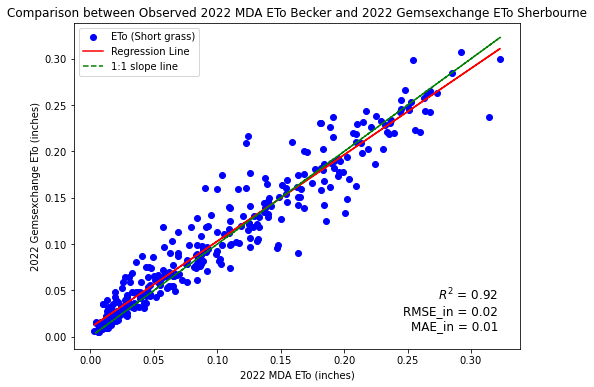

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming df_Becker and df are your DataFrames containing observed MDA ETr and observed Gemsexchange ETr respectively

# Observed MDA ETo
mda_eto = df_BeckerMDA_2022['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETo
gems_weatherbit_eto = df_GEMS_Sherbourne2022['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto, gems_weatherbit_eto)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_eto, mda_eto)

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_eto,mda_eto)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_eto,mda_eto))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto, gems_weatherbit_eto, color='blue', label='ETo (Short grass)')
plt.plot(mda_eto, slope * mda_eto + intercept, color='red', label='Regression Line')
plt.plot(mda_eto, mda_eto, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETo (inches)')
plt.ylabel('2022 Gemsexchange ETo (inches)')
plt.title('Comparison between Observed 2022 MDA ETo Becker and 2022 Gemsexchange ETo Sherbourne')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


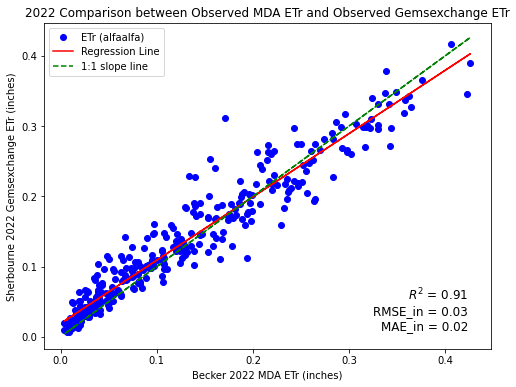

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming df_Becker and df are your DataFrames containing observed MDA ETr and observed Gemsexchange ETr respectively

# Observed MDA ETr
mda_etr = df_BeckerMDA_2022['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etr = df_GEMS_Sherbourne2022['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr, gems_weatherbit_etr)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etr,mda_etr)

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etr, mda_etr)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etr,mda_etr))


# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr, gems_weatherbit_etr, color='blue', label='ETr (alfaalfa)')
plt.plot(mda_etr, slope * mda_etr + intercept, color='red', label='Regression Line')
plt.plot(mda_etr, mda_etr, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('Becker 2022 MDA ETr (inches)')
plt.ylabel('Sherbourne 2022 Gemsexchange ETr (inches)')
plt.title('2022 Comparison between Observed MDA ETr and Observed Gemsexchange ETr')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


In [7]:
import pandas as pd

# Load the CSV file
df_GEMS_Sherbourne2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_sherbourne_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Sherbourne2023['Date'] = pd.to_datetime(df_GEMS_Sherbourne2022['Date'])

#Rename columns if necessary
df_GEMS_Sherbourne2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.792 #  latitude of the location in radian
elevation = 287  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Sherbourne2023 = ETref(df_GEMS_Sherbourne2023, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Sherbourne2023.head)



<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4738     1.0  87   975      342 2022-01-01   
1             1      1   4753    -4.2  90   981      344 2022-01-02   
2             2      2   4770    -0.6  89   970      345 2022-01-03   
3             3      3   4787     0.2  89   969      347 2022-01-04   
4             4      4   4806    -3.0  85   977      349 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4678     7.5  87   974      337 2022-12-26   
360         360    360   4687     1.1  89   981      337 2022-12-27   
361         361    361   4697     2.1  89   982      338 2022-12-28   
362         362    362   4708     5.7  81   977      339 2022-12-29   
363         363    363   4721     0.0  83   974      340 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             3.7         0.0  ...        

In [8]:
df_BeckerMDA_2023 = pd.read_csv('MDAclean_data/Becker_clean_MDA_2023.csv')
df_BeckerMDA_2023

,TIMESTAMP,RECORD,BATT_daily_min_V,RAIN_daily_in,RAIN_cmltv_in,AIRTEMP_daily_max_F,AIRTEMP_F_TMx,AIRTEMP_daily_min_F,AIRTEMP_F_TMn,AIRTEMP_daily_avg_F,...,WNDSP_daily_min_mph,WNDSP_mph_TMn,WNDSP_daily_avg_mph,WND_DIR_daily_dgr,WND_DIR_daily_crdn,SolarFlux_daily_lnglys,SolarRad_daily_mj,ETos_daily_in,ETrs_daily_in,CornGDD_daily
0,1/1/2023 23:59,669,12.47,0.00,0.00,33.74,1/1/2023 0:04,22.100,1/1/2023 23:57,26.32,...,1.043,1/1/2023 11:05,6.555,273.10,W,121.49840,6.618053,0.014,0.018,0.0
1,1/2/2023 23:59,670,12.43,0.00,0.00,23.05,1/2/2023 15:33,20.380,1/2/2023 10:49,21.90,...,0.000,1/2/2023 5:21,2.570,203.40,WNW,75.01989,6.689792,0.006,0.007,0.0
2,1/3/2023 23:59,671,12.37,0.00,0.00,29.55,1/3/2023 23:47,18.650,1/3/2023 8:16,23.46,...,2.385,1/3/2023 12:10,11.180,39.26,NE,25.75769,6.741007,0.006,0.009,0.0
3,1/4/2023 23:59,672,12.31,0.02,0.02,30.29,1/4/2023 11:19,25.060,1/4/2023 23:51,27.96,...,4.696,1/4/2023 20:46,11.460,61.92,NNE,67.40713,6.690259,0.007,0.008,0.0
4,1/5/2023 23:59,673,12.27,0.00,0.02,25.34,1/5/2023 0:00,5.104,1/5/2023 21:27,18.86,...,0.000,1/5/2023 20:41,7.703,258.90,NW,115.44460,6.856583,0.008,0.010,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,12/26/2023 23:59,1028,11.95,0.21,3.67,45.06,12/26/2023 0:03,31.650,12/26/2023 23:46,36.56,...,0.000,12/26/2023 17:26,6.881,151.00,SSE,44.10003,6.354798,0.010,0.013,0.0
360,12/27/2023 23:59,1029,11.89,0.00,3.67,34.46,12/27/2023 13:46,30.010,12/27/2023 21:24,31.83,...,0.000,12/27/2023 0:46,1.841,207.40,WSW,45.27047,6.398251,0.009,0.012,0.0
361,12/28/2023 23:59,1030,11.84,0.00,3.67,35.80,12/28/2023 15:46,30.260,12/28/2023 23:02,32.76,...,0.000,12/27/2023 23:59,7.004,297.00,NNW,45.55449,6.412548,0.012,0.017,0.0
362,12/29/2023 23:59,1031,11.80,0.00,3.67,42.67,12/29/2023 14:54,23.460,12/29/2023 6:02,31.63,...,0.000,12/29/2023 5:56,4.246,259.10,WNW,159.73670,6.472487,0.019,0.023,0.0


0.9292751052332503


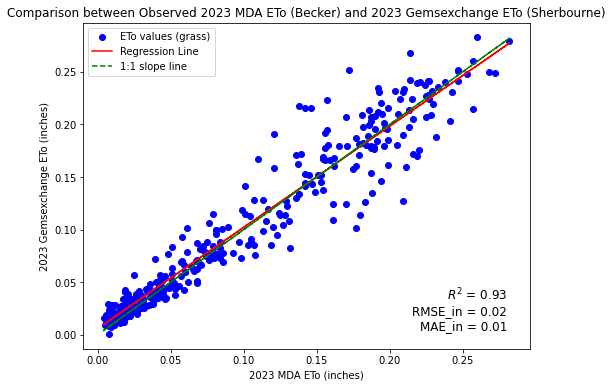

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# Observed MDA ETo
mda_eto_Becker2023 = df_BeckerMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETo
gems_weatherbit_etoSher2023 = df_GEMS_Sherbourne2023['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Becker2023, gems_weatherbit_etoSher2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoSher2023,mda_eto_Becker2023)

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoSher2023, mda_eto_Becker2023)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoSher2023, mda_eto_Becker2023))
print(r2)
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Becker2023, gems_weatherbit_etoSher2023, color='blue', label='ETo values (grass)')
plt.plot(mda_eto_Becker2023, slope * mda_eto_Becker2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Becker2023, mda_eto_Becker2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('Comparison between Observed 2023 MDA ETo (Becker) and 2023 Gemsexchange ETo (Sherbourne)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


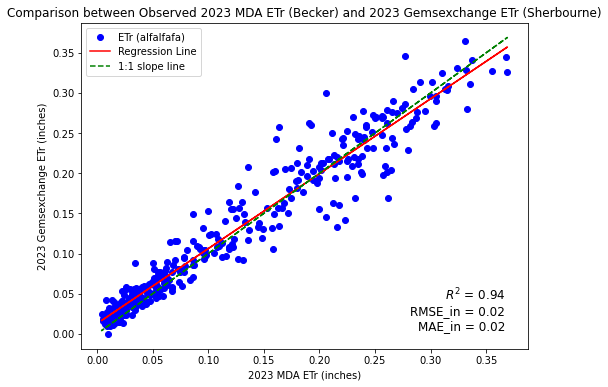

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error



# Observed MDA ETr
mda_etr_Becker2023 = df_BeckerMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrSher2023 = df_GEMS_Sherbourne2023['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Becker2023, gems_weatherbit_etrSher2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrSher2023, model.predict(mda_etr_Becker2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrSher2023, model.predict(mda_etr_Becker2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrSher2023, model.predict(mda_etr_Becker2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Becker2023, gems_weatherbit_etrSher2023, color='blue', label='ETr (alfalfafa)')
plt.plot(mda_etr_Becker2023, slope * mda_etr_Becker2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Becker2023, mda_etr_Becker2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('Comparison between Observed 2023 MDA ETr (Becker) and 2023 Gemsexchange ETr (Sherbourne)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


### Dakota and Hastings

In [11]:
import pandas as pd

# Load the CSV file
df_GEMS_Dakota2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_dakota_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Dakota2022['Date'] = pd.to_datetime(df_GEMS_Dakota2022['Date'])

#Rename columns if necessary
df_GEMS_Dakota2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define  latitude and elevation
latitude = 0.7794 #  latitude of the location in radian
elevation = 249 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Dakota2022 = ETref(df_GEMS_Dakota2022, latitude, elevation)

# Check the new columns added to  DataFrame
print(df_GEMS_Dakota2022.head)

# Export the DataFrame to a CSV file
df_GEMS_Dakota2022.to_csv('df_GEMS_Dakota2022.csv', index=False)

<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4814   -17.0  70   992      350 2022-01-01   
1             1      1   4830   -16.3  69   995      352 2022-01-02   
2             2      2   4846    -4.1  70   989      353 2022-01-03   
3             3      3   4864    -0.4  79   974      355 2022-01-04   
4             4      4   4884    -3.3  79   979      357 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4757   -11.5  71   994      344 2022-12-26   
360         360    360   4765    -5.2  70   980      345 2022-12-27   
361         361    361   4774     2.2  74   969      346 2022-12-28   
362         362    362   4785     1.9  86   974      347 2022-12-29   
363         363    363   4797    -2.6  80   985      348 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.4         0.0  ...        

In [12]:
import pandas as pd

# Load the CSV file
df_GEMS_Dakota2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_dakota_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Dakota2023['Date'] = pd.to_datetime(df_GEMS_Dakota2023['Date'])

#Rename columns if necessary
df_GEMS_Dakota2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define  latitude and elevation
latitude = 0.7794 #  latitude of the location in radian
elevation = 249 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Dakota2023 = ETref(df_GEMS_Dakota2023, latitude, elevation)

# Check the new columns added to DataFrame
print(df_GEMS_Dakota2023.head)
# Export the DataFrame to a CSV file
df_GEMS_Dakota2022.to_csv('df_GEMS_Dakota2023.csv', index=False)

<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4814     1.5  89   983      350 2023-01-01   
1             1      1   4830    -3.0  91   989      352 2023-01-02   
2             2      2   4846     0.4  89   977      353 2023-01-03   
3             3      3   4864     0.7  92   975      355 2023-01-04   
4             4      4   4884    -0.7  87   984      357 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
358         359    359   4757    10.0  82   982      344 2023-12-26   
359         360    360   4765     2.6  78   988      345 2023-12-27   
360         361    361   4774     1.1  87   989      346 2023-12-28   
361         362    362   4785     4.1  85   985      347 2023-12-29   
362         363    363   4797    -1.5  88   981      348 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             3.2         0.0  ...        

In [13]:
df_HastingsMDA_2022 = pd.read_csv('MDAclean_data/Hastings_clean_MDA_2022.csv')
df_HastingsMDA_2023 = pd.read_csv('MDAclean_data/Hastings_clean_MDA_2023.csv')


# Select the first 364 rows
df_HastingsMDA_2023 = df_HastingsMDA_2023.iloc[:363]

# Print the DataFrame
print(df_HastingsMDA_2023)

            TIMESTAMP  RECORD  BATT_daily_min_V  RAIN_daily_in  RAIN_cmltv_in  \
0      1/1/2023 23:59   754.0             12.26           0.00           0.00   
1      1/2/2023 23:59   755.0             12.17           0.00           0.00   
2      1/3/2023 23:59   756.0             12.03           0.00           0.00   
3      1/4/2023 23:59   757.0             11.89           0.29           0.29   
4      1/5/2023 23:59   758.0             11.81           0.04           0.33   
..                ...     ...               ...            ...            ...   
358  12/26/2023 23:59   299.0             11.65           0.20           1.79   
359  12/27/2023 23:59   300.0             11.80           0.00           0.00   
360  12/28/2023 23:59   301.0             12.26           0.00           0.00   
361  12/29/2023 23:59   302.0             12.19           0.00           0.00   
362  12/30/2023 23:59   303.0             12.11           0.00           0.00   

     AIRTEMP_daily_max_F   

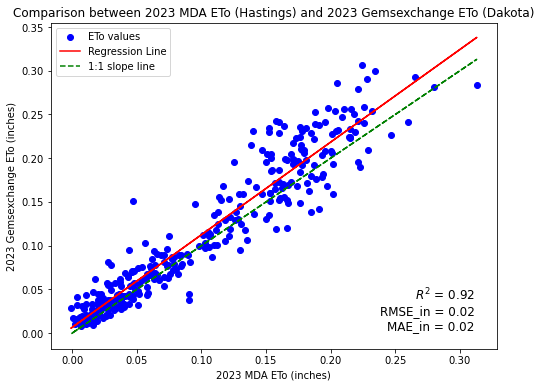

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Observed MDA ETr
mda_eto_Hastings2023 = df_HastingsMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoDak2023 = df_GEMS_Dakota2023['ETo (in/day)'].values

# Handling missing values
imputer = SimpleImputer(strategy='mean')
mda_eto_Hastings2023 = imputer.fit_transform(mda_eto_Hastings2023)

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Hastings2023, gems_weatherbit_etoDak2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoDak2023, model.predict(mda_eto_Hastings2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoDak2023, model.predict(mda_eto_Hastings2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoDak2023, model.predict(mda_eto_Hastings2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Hastings2023, gems_weatherbit_etoDak2023, color='blue', label='ETo values')
plt.plot(mda_eto_Hastings2023, slope * mda_eto_Hastings2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Hastings2023, mda_eto_Hastings2023, color='green', linestyle='--', label='1:1 slope line')

plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('Comparison between 2023 MDA ETo (Hastings) and 2023 Gemsexchange ETo (Dakota)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Define the locations and corresponding dataframes
locations = [
    ("Becker", df_BeckerMDA_2022, df_GEMS_Sherbourne2022),
    ("Clarissa", df_ClarissaMDA_2022, df_GEMS_Clarissa2022),
    ("Hubbard", df_HubbardMDA_2022, df_GEMS_Hubbard2022),
    ("Dakota", df_HastingsMDA_2022, df_GEMS_Dakota2022),
    ("LittleFalls", df_LittleFallsMDA_2022, df_GEMS_LittleFalls2022),
    ("Ottertail", df_OtterTailMDA_2022, df_GEMS_OtterTail2022),
    ("ParkersPrairie", df_ParkersPrairieMDA_2022, df_GEMS_ParkersPrairie2022),
    ("Perham", df_PerhamMDA_2022, df_GEMS_Perham2022),
    ("PinePoint", df_PinePointMDA_2022, df_GEMS_PinePoint2022),
    ("Rice", df_RiceMDA_2022, df_GEMS_Rice2022),
    ("Staples", df_StaplesMDA_2022, df_GEMS_Staples2022),
    ("Wadena", df_WadenaMDA_2022, df_GEMS_Wadena2022),
    ("Westport", df_WestportMDA_2022, df_GEMS_Douglas2022)
]

# Create subplots
num_plots = len(locations)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axs = axs.flatten()

for idx, (location_name, df_MDA, df_GEMS) in enumerate(locations):
    mda_eto = df_MDA['ETos_daily_in'].values.reshape(-1, 1)
    gems_eto = df_GEMS['ETo (in/day)'].values

    # Handling missing values
    imputer = SimpleImputer(strategy='mean')
    mda_eto = imputer.fit_transform(mda_eto)

    # Fit linear regression model
    model = LinearRegression()
    model.fit(mda_eto, gems_eto)

    # Calculate R^2, MAE, and RMSE
    r2 = r2_score(gems_eto, model.predict(mda_eto))
    mae = mean_absolute_error(gems_eto, model.predict(mda_eto))
    rmse = np.sqrt(mean_squared_error(gems_eto, model.predict(mda_eto)))

    # Plotting
    ax = axs[idx]
    ax.scatter(mda_eto, gems_eto, color='blue', label='Observed vs Predicted')
    ax.plot(mda_eto, model.predict(mda_eto), color='red', label='Regression Line')
    ax.plot(mda_eto, mda_eto, color='green', linestyle='--', label='1:1 Line')
    ax.set_xlabel('MDA ETo (inches)')
    ax.set_ylabel('GEMS ETo (inches)')
    ax.set_title(f'{location_name} 2022')
    ax.legend()
    ax.grid(False)
    ax.text(0.95, 0.05, f'$R^2$ = {r2:.5f}\nRMSE = {rmse:.5f}in\nMAE = {mae:.5f}in',
            verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=10)

# Hide any unused axes
for i in range(idx + 1, len(axs)):
    axs[i].set_visible(False)

plt.tight_layout()
plt.show()


NameError: name 'df_ClarissaMDA_2022' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Define the locations and corresponding dataframes
locations = [
    ("Becker", df_BeckerMDA_2022, df_GEMS_Sherbourne2022),
    ("Clarissa", df_ClarissaMDA_2022, df_GEMS_Clarissa2022),
    ("Hubbard", df_HubbardMDA_2022, df_GEMS_Hubbard2022),
    ("Dakota", df_HastingsMDA_2022, df_GEMS_Dakota2022),
    ("LittleFalls", df_LittleFallsMDA_2022, df_GEMS_LittleFalls2022),
    ("Ottertail", df_OtterTailMDA_2022, df_GEMS_OtterTail2022),
    ("ParkersPrairie", df_ParkersPrairieMDA_2022, df_GEMS_ParkersPrairie2022),
    ("Perham", df_PerhamMDA_2022, df_GEMS_Perham2022),
    ("PinePoint", df_PinePointMDA_2022, df_GEMS_PinePoint2022),
    ("Rice", df_RiceMDA_2022, df_GEMS_Rice2022),
    ("Staples", df_StaplesMDA_2022, df_GEMS_Staples2022),
    ("Wadena", df_WadenaMDA_2022, df_GEMS_Wadena2022),
    ("Westport", df_WestportMDA_2022, df_GEMS_Douglas2022)
]

# Combine all data
all_mda_eto = np.array([])
all_gems_eto = np.array([])

for _, df_MDA, df_GEMS in locations:
    mda_eto = df_MDA['ETos_daily_in'].values
    gems_eto = df_GEMS['ETo (in/day)'].values

    # Handling missing values with imputation
    imputer = SimpleImputer(strategy='mean')
    mda_eto_imputed = imputer.fit_transform(mda_eto.reshape(-1, 1)).flatten()

    all_mda_eto = np.concatenate([all_mda_eto, mda_eto_imputed])
    all_gems_eto = np.concatenate([all_gems_eto, gems_eto])

# Fit linear regression model
model = LinearRegression()
model.fit(all_mda_eto.reshape(-1, 1), all_gems_eto)

# Calculate metrics
predictions = model.predict(all_mda_eto.reshape(-1, 1))
r2 = r2_score(all_gems_eto, predictions)
mae = mean_absolute_error(all_gems_eto, predictions)
rmse = np.sqrt(mean_squared_error(all_gems_eto, predictions))

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(all_mda_eto, all_gems_eto, color='blue', label='Aggregated ETo values')
plt.plot(all_mda_eto, predictions, color='red', label='Regression Line')
plt.plot(all_mda_eto, all_mda_eto, color='green', linestyle='--', label='1:1 Line')
plt.xlabel('MDA ETo (inches)')
plt.ylabel('GEMS ETo (inches)')
plt.title('Evapotranspiration model Comparison Across all Locations 2022: GEMS (Gridded) vs. MDA (Non-Gridded)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, f'$R^2$ = {r2:.5f}\nRMSE = {rmse:.5f} in\nMAE = {mae:.5f} in',
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Define the locations and corresponding dataframes
locations = [
    ("Becker23", df_BeckerMDA_2023, df_GEMS_Sherbourne2023),
    ("Clarissa23", df_ClarissaMDA_2023, df_GEMS_Clarissa2023),
    ("Hubbard23", df_HubbardMDA_2023, df_GEMS_Hubbard2023),
    ("Dakota23", df_HastingsMDA_2023, df_GEMS_Dakota2023),
    ("LittleFalls23", df_LittleFallsMDA_2023, df_GEMS_LittleFalls2023),
    ("Ottertail23", df_OtterTailMDA_2023, df_GEMS_OtterTail2023),
    ("ParkersPrairie23", df_ParkersPrairieMDA_2023, df_GEMS_ParkersPrairie2023),
    ("Perham23", df_PerhamMDA_2023, df_GEMS_Perham2023),
    ("PinePoint23", df_PinePointMDA_2023, df_GEMS_PinePoint2023),
    ("Rice23", df_RiceMDA_2023, df_GEMS_Rice2023),
    ("Staples", df_StaplesMDA_2023, df_GEMS_Staples2023),
    ("Wadena", df_WadenaMDA_2023, df_GEMS_Wadena2023),
    ("Westport", df_WestportMDA_2023, df_GEMS_Douglas2023)
]

# Create subplots
num_plots = len(locations)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axs = axs.flatten()

for idx, (location_name, df_MDA, df_GEMS) in enumerate(locations):
    mda_eto = df_MDA['ETos_daily_in'].values.reshape(-1, 1)
    gems_eto = df_GEMS['ETo (in/day)'].values

    # Handling missing values
    imputer = SimpleImputer(strategy='mean')
    mda_eto = imputer.fit_transform(mda_eto)

    # Fit linear regression model
    model = LinearRegression()
    model.fit(mda_eto, gems_eto)

    # Calculate R^2, MAE, and RMSE
    r2 = r2_score(gems_eto, model.predict(mda_eto))
    mae = mean_absolute_error(gems_eto, model.predict(mda_eto))
    rmse = np.sqrt(mean_squared_error(gems_eto, model.predict(mda_eto)))

    # Plotting
    ax = axs[idx]
    ax.scatter(mda_eto, gems_eto, color='blue', label='Observed vs Predicted')
    ax.plot(mda_eto, model.predict(mda_eto), color='red', label='Regression Line')
    ax.plot(mda_eto, mda_eto, color='green', linestyle='--', label='1:1 Line')
    ax.set_xlabel('MDA ETo (inches)')
    ax.set_ylabel('GEMS ETo (inches)')
    ax.set_title(f'{location_name} 2023')
    ax.legend()
    ax.grid(False)
    ax.text(0.95, 0.05, f'$R^2$ = {r2:.5f}\nRMSE = {rmse:.5f} in\nMAE = {mae:.5f} in',
            verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=10)

# Hide any unused axes
for i in range(idx + 1, len(axs)):
    axs[i].set_visible(False)

plt.tight_layout()
plt.show()


NameError: name 'df_ClarissaMDA_2023' is not defined

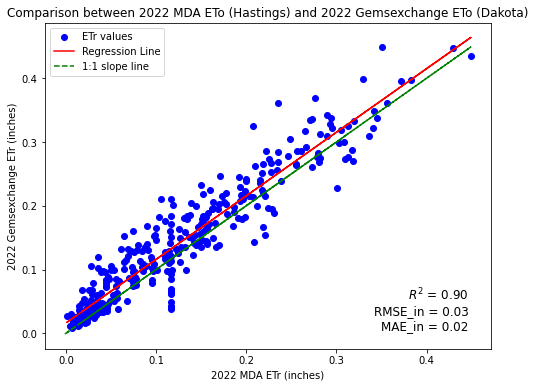

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Observed MDA ETr
mda_etr_Hastings2022 = df_HastingsMDA_2022['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrDak2022 = df_GEMS_Dakota2022['ETr (in/day)'].values

# Handling missing values
imputer = SimpleImputer(strategy='mean')
mda_etr_Hastings2022 = imputer.fit_transform(mda_etr_Hastings2022)

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Hastings2022, gems_weatherbit_etrDak2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrDak2022, model.predict(mda_etr_Hastings2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrDak2022, model.predict(mda_etr_Hastings2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrDak2022, model.predict(mda_etr_Hastings2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Hastings2022, gems_weatherbit_etrDak2022, color='blue', label='ETr values')
plt.plot(mda_etr_Hastings2022, slope * mda_etr_Hastings2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Hastings2022, mda_etr_Hastings2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETr (inches)')
plt.ylabel('2022 Gemsexchange ETr (inches)')
plt.title('Comparison between 2022 MDA ETo (Hastings) and 2022 Gemsexchange ETo (Dakota)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
# Add a 1:1 line
min_val = min(mda_eto_Hastings2023.min(), gems_weatherbit_etoDak2023.min())
max_val = max(mda_eto_Hastings2023.max(), gems_weatherbit_etoDak2023.max())
plt.plot([min_val, max_val], [min_val, max_val], color='green', linestyle='--', label='1:1 Line')

plt.show()


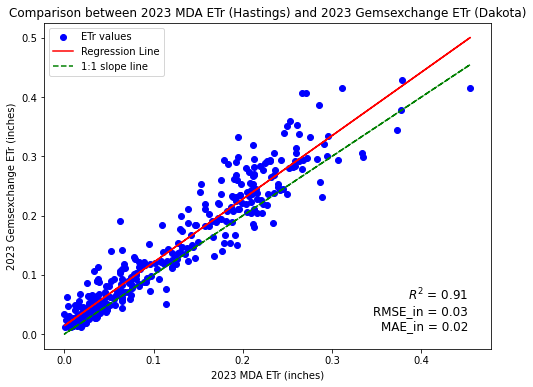

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Assuming df_HastingsMDA_2023 and df_GEMS_Dakota2023 are your DataFrames containing observed MDA ETr and Gemsexchange ETr respectively

# Observed MDA ETr
mda_etr_Hastings2023 = df_HastingsMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrDak2023 = df_GEMS_Dakota2023['ETr (in/day)'].values

# Handling missing values
imputer = SimpleImputer(strategy='mean')
mda_etr_Hastings2023 = imputer.fit_transform(mda_etr_Hastings2023)

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Hastings2023, gems_weatherbit_etrDak2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrDak2023, model.predict(mda_etr_Hastings2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrDak2023, model.predict(mda_etr_Hastings2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrDak2023, model.predict(mda_etr_Hastings2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Hastings2023, gems_weatherbit_etrDak2023, color='blue', label='ETr values')
plt.plot(mda_etr_Hastings2023, slope * mda_etr_Hastings2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Hastings2023, mda_etr_Hastings2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('Comparison between 2023 MDA ETr (Hastings) and 2023 Gemsexchange ETr (Dakota)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


### Douglas and Westport

In [19]:
import pandas as pd

# Load the CSV file
df_GEMS_Douglas2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_douglas_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Douglas2022['Date'] = pd.to_datetime(df_GEMS_Douglas2022['Date'])

#Rename columns if necessary
df_GEMS_Douglas2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.7960 #  latitude of the location in radian
elevation = 409 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Douglas2022 = ETref(df_GEMS_Douglas2022, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Douglas2022.head)

<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4700   -24.0  72   971      333 2022-01-01   
1             1      1   4715   -16.0  78   970      335 2022-01-02   
2             2      2   4731    -4.0  84   966      336 2022-01-03   
3             3      3   4748    -8.0  91   953      338 2022-01-04   
4             4      4   4766   -12.0  82   962      340 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4639   -14.0  75   972      328 2022-12-26   
360         360    360   4648    -3.5  83   952      329 2022-12-27   
361         361    361   4658     2.0  89   944      330 2022-12-28   
362         362    362   4670    -2.0  93   954      331 2022-12-29   
363         363    363   4682    -7.0  86   962      332 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.4         0.0  ...        

In [20]:
import pandas as pd

# Load the CSV file
df_GEMS_Douglas2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_douglas_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Douglas2023['Date'] = pd.to_datetime(df_GEMS_Douglas2023['Date'])

#Rename columns if necessary
df_GEMS_Douglas2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.7960 #  latitude of the location in radian
elevation = 409 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Douglas2023 = ETref(df_GEMS_Douglas2023, latitude, elevation)

# Check the new columns added to your DataFrame
print(df_GEMS_Douglas2023.head)



<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4700      -4  96   962      333 2023-01-01   
1             1      1   4715      -6  94   967      335 2023-01-02   
2             2      2   4731      -4  90   958      336 2023-01-03   
3             3      3   4748      -3  89   958      338 2023-01-04   
4             4      4   4766      -5  88   964      340 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4639       4  96   960      328 2023-12-26   
360         360    360   4648       0  95   967      329 2023-12-27   
361         361    361   4658       1  97   969      330 2023-12-28   
362         362    362   4670       4  90   964      331 2023-12-29   
363         363    363   4682      -2  89   961      332 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.8         0.0  ...        

In [21]:
df_WestportMDA_2022 = pd.read_csv('MDAclean_data/Westport_clean_MDA_2022.csv')
df_WestportMDA_2023 = pd.read_csv('MDAclean_data/Westport_clean_MDA_2023.csv')

# Print the DataFrame
print(df_WestportMDA_2022)


            TIMESTAMP  RAIN_daily_in  RAIN_cmltv_in  AIRTEMP_daily_max_F  \
0      1/1/2022 23:59           0.00           0.00              -11.940   
1      1/2/2022 23:59           0.00           0.00                3.218   
2      1/3/2022 23:59           0.02           0.02               20.930   
3      1/4/2022 23:59           0.00           0.02               18.830   
4      1/5/2022 23:59           0.00           0.02               10.720   
..                ...            ...            ...                  ...   
359  12/26/2022 23:59           0.00          22.35                6.344   
360  12/27/2022 23:59           0.00          22.35               24.910   
361  12/28/2022 23:59           0.06          22.41               33.240   
362  12/29/2022 23:59           0.00          22.41               28.600   
363  12/30/2022 23:59           0.00          22.41               19.320   

        AIRTEMP_F_TMx  AIRTEMP_daily_min_F     AIRTEMP_F_TMn  \
0      1/1/2022 14:33  

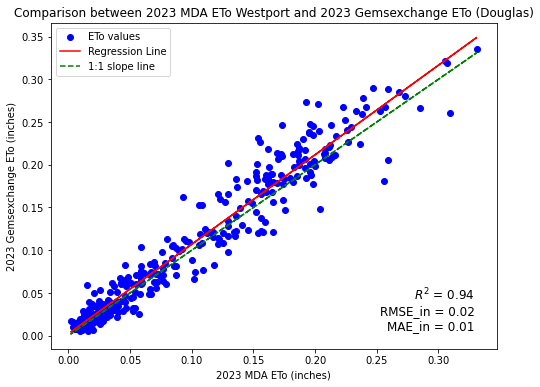

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming df_Becker and df are your DataFrames containing observed MDA ETr and observed Gemsexchange ETr respectively

# Observed MDA ETo
mda_eto_Westport2023 = df_WestportMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETo
gems_weatherbit_etoDoug2023 = df_GEMS_Douglas2023['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Westport2023, gems_weatherbit_etoDoug2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoDoug2023, model.predict(mda_eto_Westport2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoDoug2023, model.predict(mda_eto_Westport2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoDoug2023, model.predict(mda_eto_Westport2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Westport2023, gems_weatherbit_etoDoug2023, color='blue', label='ETo values')
plt.plot(mda_eto_Westport2023, slope * mda_eto_Westport2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Westport2023, mda_eto_Westport2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('Comparison between 2023 MDA ETo Westport and 2023 Gemsexchange ETo (Douglas)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


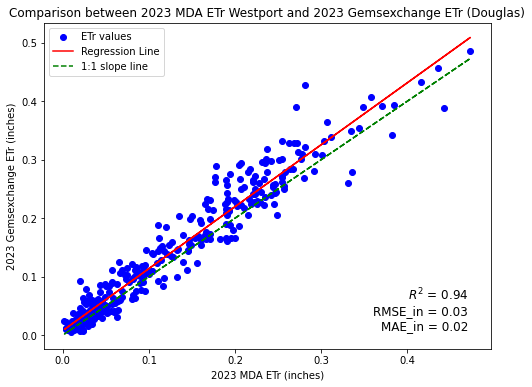

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming df_Becker and df are your DataFrames containing observed MDA ETr and observed Gemsexchange ETr respectively

# Observed MDA ETr
mda_etr_Westport2023 = df_WestportMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETo
gems_weatherbit_etrDoug2023 = df_GEMS_Douglas2023['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Westport2023, gems_weatherbit_etrDoug2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrDoug2023, model.predict(mda_etr_Westport2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrDoug2023, model.predict(mda_etr_Westport2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrDoug2023, model.predict(mda_etr_Westport2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Westport2023, gems_weatherbit_etrDoug2023, color='blue', label='ETr values')
plt.plot(mda_etr_Westport2023, slope * mda_etr_Westport2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Westport2023, mda_etr_Westport2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('Comparison between 2023 MDA ETr Westport and 2023 Gemsexchange ETr (Douglas)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


#### Calculate GEMS weather ET for all station for 2022 and 2023 Clarissa

In [24]:
import pandas as pd

# Load the CSV file
df_GEMS_Clarissa2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Clarissa_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Clarissa2022['Date'] = pd.to_datetime(df_GEMS_Clarissa2022['Date'])

#Rename columns if necessary
df_GEMS_Clarissa2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.80457 #  latitude of the location in radian
elevation = 397 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Clarissa2022 = ETref(df_GEMS_Clarissa2022, latitude, elevation)

print(df_GEMS_Clarissa2022.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4657   -24.4  68   972      329 2022-01-01   
1             1      1   4673   -16.3  71   971      331 2022-01-02   
2             2      2   4689    -7.0  78   967      332 2022-01-03   
3             3      3   4707    -5.9  83   955      334 2022-01-04   
4             4      4   4725    -9.6  76   963      336 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4593   -13.7  71   974      324 2022-12-26   
360         360    360   4603    -4.4  77   954      325 2022-12-27   
361         361    361   4614     2.2  84   946      325 2022-12-28   
362         362    362   4626    -1.9  87   955      326 2022-12-29   
363         363    363   4639    -7.0  79   964      328 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.0         0.0  ...        

In [25]:
import pandas as pd

# Load the CSV file
df_GEMS_Clarissa2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Clarissa_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Clarissa2023['Date'] = pd.to_datetime(df_GEMS_Clarissa2023['Date'])

#Rename columns if necessary
df_GEMS_Clarissa2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.80457 #  latitude of the location in radian
elevation = 397 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Clarissa2023 = ETref(df_GEMS_Clarissa2023, latitude, elevation)

print(df_GEMS_Clarissa2023.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4657    -1.9  89   963      329 2023-01-01   
1             1      1   4673    -4.8  91   969      331 2023-01-02   
2             2      2   4689    -5.2  87   960      332 2023-01-03   
3             3      3   4707    -3.7  85   960      334 2023-01-04   
4             4      4   4725    -5.9  83   966      336 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4593     4.1  95   962      324 2023-12-26   
360         360    360   4603     1.5  90   969      325 2023-12-27   
361         361    361   4614     1.5  92   971      325 2023-12-28   
362         362    362   4626     3.7  86   965      326 2023-12-29   
363         363    363   4639    -1.1  80   963      328 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.0         0.0  ...        

## GEMS Hubbard 2022 and 2023)

In [26]:

# Load the CSV file
df_GEMS_Clarissa2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Clarissa_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Clarissa2023['Date'] = pd.to_datetime(df_GEMS_Clarissa2023['Date'])

#Rename columns if necessary
df_GEMS_Clarissa2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.80457 #  latitude of the location in radian
elevation = 397 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Clarissa2023 = ETref(df_GEMS_Clarissa2023, latitude, elevation)



In [27]:
import pandas as pd

# Load the CSV file
df_GEMS_Hubbard2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Hubbard_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Hubbard2022['Date'] = pd.to_datetime(df_GEMS_Hubbard2022['Date'])

#Rename columns if necessary
df_GEMS_Hubbard2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.80457 #  latitude of the location in radian
elevation = 397 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Hubbard2022 = ETref(df_GEMS_Hubbard2022, latitude, elevation)

print(df_GEMS_Hubbard2022.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4505   -23.3  81   968      311 2022-01-01   
1             1      1   4522   -18.3  78   966      312 2022-01-02   
2             2      2   4540    -7.8  80   963      314 2022-01-03   
3             3      3   4559    -6.7  84   952      315 2022-01-04   
4             4      4   4578   -11.1  73   960      317 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4438   -12.8  70   969      305 2022-12-26   
360         360    360   4448    -6.1  79   949      306 2022-12-27   
361         361    361   4460    -1.1  87   943      307 2022-12-28   
362         362    362   4472    -3.3  92   951      308 2022-12-29   
363         363    363   4486    -8.9  84   959      309 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.0         0.0  ...        

In [28]:
import pandas as pd

# Load the CSV file
df_GEMS_Hubbard2023= pd.read_csv('Gemsexchage_data/gems_weather_export_Hubbard_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Hubbard2023['Date'] = pd.to_datetime(df_GEMS_Hubbard2023['Date'])

#Rename columns if necessary
df_GEMS_Hubbard2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define  latitude and elevation
latitude = 0.81723 #  latitude of the location in radian
elevation = 429 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Hubbard2023 = ETref(df_GEMS_Hubbard2023, latitude, elevation)

print(df_GEMS_Hubbard2023.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4505    -2.0  89   958      311 2023-01-01   
1             1      1   4522    -6.7  88   964      312 2023-01-02   
2             2      2   4540    -6.0  85   958      314 2023-01-03   
3             3      3   4559    -3.9  80   958      315 2023-01-04   
4             4      4   4578    -6.1  86   962      317 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4438     3.9  97   959      305 2023-12-26   
360         360    360   4448     2.2  95   964      306 2023-12-27   
361         361    361   4460     3.3  91   967      307 2023-12-28   
362         362    362   4472     5.6  86   961      308 2023-12-29   
363         363    363   4486    -2.2  85   959      309 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             6.7         0.0  ...        

### GEMS ET (LittleFalls 2022 and  2023)

In [29]:
import pandas as pd

# Load the CSV file
df_GEMS_LittleFalls2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_LittleFalls_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_LittleFalls2022['Date'] = pd.to_datetime(df_GEMS_LittleFalls2022['Date'])

#Rename columns if necessary
df_GEMS_LittleFalls2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.80005 #  latitude of the location in radian
elevation = 338  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_LittleFalls2022 = ETref(df_GEMS_LittleFalls2022, latitude, elevation)

print(df_GEMS_LittleFalls2022.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4637   -22.0  68   981      329 2022-01-01   
1             1      1   4653   -18.0  72   981      330 2022-01-02   
2             2      2   4670    -5.0  81   976      332 2022-01-03   
3             3      3   4688    -6.0  84   963      333 2022-01-04   
4             4      4   4707    -9.0  77   971      335 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4571   -12.0  67   982      323 2022-12-26   
360         360    360   4581    -5.0  75   963      324 2022-12-27   
361         361    361   4592     1.0  85   955      325 2022-12-28   
362         362    362   4605    -1.0  92   964      326 2022-12-29   
363         363    363   4618    -8.0  79   972      327 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             3.2         0.0  ...        

In [30]:
import pandas as pd

# Load the CSV file
df_GEMS_LittleFalls2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_LittleFalls_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_LittleFalls2023['Date'] = pd.to_datetime(df_GEMS_LittleFalls2023['Date'])

#Rename columns if necessary
df_GEMS_LittleFalls2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.80005 #  latitude of the location in radian
elevation = 338  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_LittleFalls2023 = ETref(df_GEMS_LittleFalls2023, latitude, elevation)

print(df_GEMS_LittleFalls2023.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4637     0.0  89   971      329 2023-01-01   
1             1      1   4653    -5.0  92   977      330 2023-01-02   
2             2      2   4670    -3.0  90   968      332 2023-01-03   
3             3      3   4688    -2.0  88   967      333 2023-01-04   
4             4      4   4707    -3.0  89   974      335 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4571     3.0  98   970      323 2023-12-26   
360         360    360   4581     0.0  98   976      324 2023-12-27   
361         361    361   4592     2.0  95   978      325 2023-12-28   
362         362    362   4605     5.0  90   973      326 2023-12-29   
363         363    363   4618    -2.0  86   970      327 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.3         0.0  ...        

 ### GEMS ET (Ottertail 2022 and  2023)

In [31]:
import pandas as pd

# Load the CSV file
df_GEMS_OtterTail2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_OtterTail_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_OtterTail2022['Date'] = pd.to_datetime(df_GEMS_OtterTail2022['Date'])

#Rename columns if necessary
df_GEMS_OtterTail2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.81021  #  latitude of the location in radian
elevation = 413  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_OtterTail2022 = ETref(df_GEMS_OtterTail2022, latitude, elevation)

print(df_GEMS_OtterTail2022.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4576   -25.9  71   970      319 2022-01-01   
1             1      1   4592   -17.0  72   968      320 2022-01-02   
2             2      2   4609    -9.3  77   965      322 2022-01-03   
3             3      3   4627    -7.0  84   954      323 2022-01-04   
4             4      4   4646   -10.4  76   963      325 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4511   -15.6  72   971      313 2022-12-26   
360         360    360   4521    -5.2  78   951      314 2022-12-27   
361         361    361   4532     1.1  85   944      315 2022-12-28   
362         362    362   4544    -2.6  88   953      316 2022-12-29   
363         363    363   4558    -8.5  81   962      317 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             3.6         0.0  ...        

In [32]:
import pandas as pd

# Load the CSV file
df_GEMS_OtterTail2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_OtterTail_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_OtterTail2023['Date'] = pd.to_datetime(df_GEMS_OtterTail2023['Date'])

#Rename columns if necessary
df_GEMS_OtterTail2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define  latitude and elevation
latitude = 0.81021  #  latitude of the location in radian
elevation = 413  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_OtterTail2023 = ETref(df_GEMS_OtterTail2023, latitude, elevation)

print(df_GEMS_OtterTail2023.head)

<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4576    -3.3  91   961      319 2023-01-01   
1             1      1   4592    -7.4  92   967      320 2023-01-02   
2             2      2   4609    -6.7  88   959      322 2023-01-03   
3             3      3   4627    -5.2  82   960      323 2023-01-04   
4             4      4   4646    -8.1  86   964      325 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4511     3.3  98   961      313 2023-12-26   
360         360    360   4521     1.5  95   967      314 2023-12-27   
361         361    361   4532     1.1  95   970      315 2023-12-28   
362         362    362   4544     2.6  90   963      316 2023-12-29   
363         363    363   4558    -2.2  82   962      317 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.0         0.0  ...        

### Parkers Prairie GEMS 

In [33]:
import pandas as pd

# Load the CSV file
df_GEMS_ParkersPrairie2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_ParkersPrairie_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_ParkersPrairie2022['Date'] = pd.to_datetime(df_GEMS_ParkersPrairie2022['Date'])

#Rename columns if necessary
df_GEMS_ParkersPrairie2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.80542  #  latitude of the location in radian
elevation = 448  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_ParkersPrairie2022 = ETref(df_GEMS_ParkersPrairie2022, latitude, elevation)

print(df_GEMS_ParkersPrairie2022.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4669   -25.2  69   967      329 2022-01-01   
1             1      1   4685   -16.3  70   965      331 2022-01-02   
2             2      2   4701    -7.4  77   962      332 2022-01-03   
3             3      3   4718    -6.3  83   951      334 2022-01-04   
4             4      4   4736   -10.0  76   959      336 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4608   -14.8  71   968      324 2022-12-26   
360         360    360   4617    -4.4  77   949      325 2022-12-27   
361         361    361   4627     1.9  85   941      325 2022-12-28   
362         362    362   4639    -2.2  88   950      326 2022-12-29   
363         363    363   4652    -7.8  80   959      328 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             3.6         0.0  ...        

In [34]:
import pandas as pd

# Load the CSV file
df_GEMS_ParkersPrairie2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_ParkersPrairie_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_ParkersPrairie2023['Date'] = pd.to_datetime(df_GEMS_ParkersPrairie2023['Date'])

#Rename columns if necessary
df_GEMS_ParkersPrairie2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.80542  #  latitude of the location in radian
elevation = 448  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_ParkersPrairie2023 = ETref(df_GEMS_ParkersPrairie2023, latitude, elevation)

print(df_GEMS_ParkersPrairie2023.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4669    -2.6  90   958      329 2023-01-01   
1             1      1   4685    -5.9  91   964      331 2023-01-02   
2             2      2   4701    -6.3  88   956      332 2023-01-03   
3             3      3   4718    -4.8  84   956      334 2023-01-04   
4             4      4   4736    -7.0  84   961      336 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4608     4.1  96   958      324 2023-12-26   
360         360    360   4617     1.5  92   964      325 2023-12-27   
361         361    361   4627     1.5  93   967      325 2023-12-28   
362         362    362   4639     3.0  88   960      326 2023-12-29   
363         363    363   4652    -1.9  81   959      328 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.0         0.0  ...        

### Perham 2022 and 2023

In [35]:
import pandas as pd

# Load the CSV file
df_GEMS_Perham2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Perham_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Perham2022['Date'] = pd.to_datetime(df_GEMS_Perham2022['Date'])

#Rename columns if necessary
df_GEMS_Perham2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.80542  #  latitude of the location in radian
elevation = 448  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Perham2022 = ETref(df_GEMS_Perham2022, latitude, elevation)

print(df_GEMS_Perham2022.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4519   -25.9  71   971      311 2022-01-01   
1             1      1   4535   -17.0  72   969      312 2022-01-02   
2             2      2   4552    -9.3  77   966      314 2022-01-03   
3             3      3   4571    -7.0  84   955      315 2022-01-04   
4             4      4   4590   -10.4  76   964      317 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4455   -15.6  72   972      306 2022-12-26   
360         360    360   4465    -5.2  78   952      306 2022-12-27   
361         361    361   4476     1.1  85   945      307 2022-12-28   
362         362    362   4488    -2.6  88   954      308 2022-12-29   
363         363    363   4501    -8.5  81   963      309 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             3.6         0.0  ...        

In [36]:
import pandas as pd

# Load the CSV file
df_GEMS_Perham2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Perham_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Perham2023['Date'] = pd.to_datetime(df_GEMS_Perham2023['Date'])

#Rename columns if necessary
df_GEMS_Perham2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define latitude and elevation
latitude = 0.8146 # Check this latitude #  latitude of the location in radian
elevation = 419  #the actual elevation of the location in meters 

#  Call the ETref function
df_GEMS_Perham2023 = ETref(df_GEMS_Perham2023, latitude, elevation)
print(df_GEMS_Perham2023.head)

<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4519    -3.3  91   962      311 2023-01-01   
1             1      1   4535    -7.4  92   968      312 2023-01-02   
2             2      2   4552    -6.7  88   960      314 2023-01-03   
3             3      3   4571    -5.2  82   961      315 2023-01-04   
4             4      4   4590    -8.1  86   965      317 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4455     3.3  98   962      306 2023-12-26   
360         360    360   4465     1.5  95   968      306 2023-12-27   
361         361    361   4476     1.1  95   971      307 2023-12-28   
362         362    362   4488     2.6  90   964      308 2023-12-29   
363         363    363   4501    -2.2  82   963      309 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.0         0.0  ...        

### PinePoint 2022 and 2023 

In [37]:
import pandas as pd

# Load the CSV file
df_GEMS_PinePoint2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_PinePoint_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_PinePoint2022['Date'] = pd.to_datetime(df_GEMS_PinePoint2022['Date'])

#Rename columns if necessary
df_GEMS_PinePoint2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.8205  #  latitude of the location in radian
elevation = 476  #  the actual elevation of the location in meters 
#  Call the ETref function
df_GEMS_PPinePoint2022 = ETref(df_GEMS_PinePoint2022, latitude, elevation)

print(df_GEMS_PinePoint2022.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4505   -24.1  69   963      311 2022-01-01   
1             1      1   4522   -17.0  70   961      312 2022-01-02   
2             2      2   4540    -9.3  77   959      314 2022-01-03   
3             3      3   4559    -7.8  84   949      315 2022-01-04   
4             4      4   4578   -11.5  75   957      317 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
357         359    359   4438   -13.7  70   965      305 2022-12-26   
358         360    360   4448    -4.4  78   945      306 2022-12-27   
359         361    361   4460     0.7  87   939      307 2022-12-28   
360         362    362   4472    -3.0  90   947      308 2022-12-29   
361         363    363   4486    -8.1  81   956      309 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             2.8         0.0  ...        

In [38]:
import pandas as pd

# Load the CSV file
df_GEMS_PinePoint2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_PinePoint_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_PinePoint2023['Date'] = pd.to_datetime(df_GEMS_PinePoint2023['Date'])

#Rename columns if necessary
df_GEMS_PinePoint2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.8205  #  latitude of the location in radian
elevation = 476  #  the actual elevation of the location in meters 

#  Call the ETref function
df_GEMS_PinePoint2023 = ETref(df_GEMS_PinePoint2023, latitude, elevation)

print(df_GEMS_PinePoint2023.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4505    -2.2  91   955      311 2023-01-01   
1             1      1   4522    -6.7  91   961      312 2023-01-02   
2             2      2   4540    -7.0  88   954      314 2023-01-03   
3             3      3   4559    -6.3  82   954      315 2023-01-04   
4             4      4   4578    -8.1  85   958      317 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4438     2.6  99   956      305 2023-12-26   
360         360    360   4448     1.1  97   961      306 2023-12-27   
361         361    361   4460     1.1  94   964      307 2023-12-28   
362         362    362   4472     2.2  88   957      308 2023-12-29   
363         363    363   4486    -3.0  83   956      309 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             3.6         0.0  ...        

### Rice 2022 and 2023 

In [39]:

# Load the CSV file
df_GEMS_Rice2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Rice_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Rice2022['Date'] = pd.to_datetime(df_GEMS_Rice2022['Date'])

#Rename columns if necessary
df_GEMS_Rice2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.798  #  latitude of the location in radian
elevation = 328  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Rice2022 = ETref(df_GEMS_Rice2022, latitude, elevation)

print(df_GEMS_Rice2022.head)


<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4637   -22.0  68   981      329 2022-01-01   
1             1      1   4653   -18.0  72   981      330 2022-01-02   
2             2      2   4670    -5.0  81   976      332 2022-01-03   
3             3      3   4688    -6.0  84   963      333 2022-01-04   
4             4      4   4707    -9.0  77   971      335 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4571   -12.0  67   985      323 2022-12-26   
360         360    360   4581    -5.0  75   967      324 2022-12-27   
361         361    361   4592     1.0  85   958      325 2022-12-28   
362         362    362   4605    -1.0  92   964      326 2022-12-29   
363         363    363   4618    -8.0  79   972      327 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             3.6         0.0  ...        

In [40]:
#Load the CSV file
df_GEMS_Rice2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Rice_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Rice2023['Date'] = pd.to_datetime(df_GEMS_Rice2023['Date'])

#Rename columns if necessary
df_GEMS_Rice2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude = 0.7989   #  latitude of the location in radian
elevation = 328  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Rice2023 = ETref(df_GEMS_Rice2023, latitude, elevation)

print(df_GEMS_Rice2023.head)

<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4637     0.0  89   971      329 2023-01-01   
1             1      1   4653    -5.0  92   977      330 2023-01-02   
2             2      2   4670    -3.0  90   968      332 2023-01-03   
3             3      3   4688    -2.0  88   967      333 2023-01-04   
4             4      4   4707    -3.0  89   974      335 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4571     3.0  98   970      323 2023-12-26   
360         360    360   4581     0.0  98   976      324 2023-12-27   
361         361    361   4592     2.0  95   978      325 2023-12-28   
362         362    362   4605     5.0  90   973      326 2023-12-29   
363         363    363   4618    -2.0  86   970      327 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             4.3         0.0  ...        

### Staples 2022 and 2023 

In [41]:
# Load the CSV file
df_GEMS_Staples2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Staples_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Staples2022['Date'] = pd.to_datetime(df_GEMS_Staples2022['Date'])

#Rename columns if necessary
df_GEMS_Staples2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude =  0.80925 #  latitude of the location in radian
elevation = 391  #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Staples2022 = ETref(df_GEMS_Staples2022, latitude, elevation)

print(df_GEMS_Staples2022.head)

<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4581     -25  68   975      320 2022-01-01   
1             1      1   4597     -17  68   973      322 2022-01-02   
2             2      2   4615      -7  80   969      323 2022-01-03   
3             3      3   4633      -6  84   957      325 2022-01-04   
4             4      4   4652      -9  75   965      327 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4515     -12  69   975      315 2022-12-26   
360         360    360   4525      -5  77   956      316 2022-12-27   
361         361    361   4537       1  86   949      317 2022-12-28   
362         362    362   4549      -2  95   957      318 2022-12-29   
363         363    363   4563      -8  83   966      319 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             2.4         0.0  ...        

In [42]:
# Load the CSV file
df_GEMS_Staples2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Staples_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Staples2023['Date'] = pd.to_datetime(df_GEMS_Staples2023['Date'])

#Rename columns if necessary
df_GEMS_Staples2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude =  0.80925  #  latitude of the location in radian
elevation = 391 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Staples2023 = ETref(df_GEMS_Staples2023, latitude, elevation)

print(df_GEMS_Staples2023.head)

<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4581      -1  95   965      320 2023-01-01   
1             1      1   4597      -6  94   970      322 2023-01-02   
2             2      2   4615      -4  91   963      323 2023-01-03   
3             3      3   4633      -3  87   963      325 2023-01-04   
4             4      4   4652       0  89   968      327 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4515       6  93   964      315 2023-12-26   
360         360    360   4525       3  94   970      316 2023-12-27   
361         361    361   4537       3  94   973      317 2023-12-28   
362         362    362   4549       6  87   967      318 2023-12-29   
363         363    363   4563      -2  85   965      319 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             3.7         0.0  ...        

### GEMS Wadena 2022 and 2023

In [43]:
# Load the CSV file
df_GEMS_Wadena2022 = pd.read_csv('Gemsexchage_data/gems_weather_export_Wadena_2022-01-01_to_2022-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Wadena2022['Date'] = pd.to_datetime(df_GEMS_Wadena2022['Date'])

#Rename columns if necessary
df_GEMS_Wadena2022.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude =  0.81034  #  latitude of the location in radian
elevation = 416 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Wadena2022 = ETref(df_GEMS_Wadena2022, latitude, elevation)

print(df_GEMS_Wadena2022.head)

<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4576   -26.0  69   971      319 2022-01-01   
1             1      1   4592   -19.0  72   970      320 2022-01-02   
2             2      2   4609    -8.0  82   966      322 2022-01-03   
3             3      3   4627    -7.0  86   954      323 2022-01-04   
4             4      4   4647   -12.0  76   963      325 2022-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4511   -13.0  69   972      313 2022-12-26   
360         360    360   4521    -5.0  79   952      314 2022-12-27   
361         361    361   4532     0.0  88   945      315 2022-12-28   
362         362    362   4545    -3.0  94   954      316 2022-12-29   
363         363    363   4558    -9.0  85   963      317 2022-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             2.4         0.0  ...        

In [44]:
# Load the CSV file
df_GEMS_Wadena2023 = pd.read_csv('Gemsexchage_data/gems_weather_export_Wadena_2023-01-01_to_2023-12-31_units(M).csv')

# Make sure 'Date' is in datetime format
df_GEMS_Wadena2023['Date'] = pd.to_datetime(df_GEMS_Wadena2023['Date'])

#Rename columns if necessary
df_GEMS_Wadena2023.rename(columns={'Date': 'Date', 'wind_spd': 'U3_m_s-1','solar_rad' : 'Rs_W_m2','max_temp' : 'Tmax_C' , 'min_temp':'Tmin_C', 'dewpt': 'T_dew_C'}, inplace=True)

# Define your latitude and elevation
latitude =  0.81034  #  latitude of the location in radian
elevation = 416 #  the actual elevation of the location in meters #Here I kept same elevation as Becker. 

#  Call the ETref function
df_GEMS_Wadena2023 = ETref(df_GEMS_Wadena2023, latitude, elevation)

print(df_GEMS_Wadena2023.head)

<bound method NDFrame.head of      Unnamed: 0  index  t_dni  Tmax_C  rh  pres  max_ghi       Date  \
0             0      0   4576    -2.0  96   962      319 2023-01-01   
1             1      1   4592    -7.0  93   967      320 2023-01-02   
2             2      2   4609    -5.0  91   960      322 2023-01-03   
3             3      3   4627    -4.0  88   960      323 2023-01-04   
4             4      4   4647    -7.0  91   965      325 2023-01-05   
..          ...    ...    ...     ...  ..   ...      ...        ...   
359         359    359   4511     4.0  94   961      313 2023-12-26   
360         360    360   4521     2.0  94   967      314 2023-12-27   
361         361    361   4532     3.0  92   970      315 2023-12-28   
362         362    362   4545     3.0  90   964      316 2023-12-29   
363         363    363   4558    -3.0  85   962      317 2023-12-30   

     max_wind_spd  precip_gpm  ...  Inverse Relative Distance Earth-Sun  \
0             2.8         0.0  ...        

### MDA 2022 and 2023 datasets 

In [45]:
df_ClarissaMDA_2022 = pd.read_csv('MDAclean_data/Clarissa_clean_MDA_2022.csv')
df_ClarissaMDA_2023 = pd.read_csv('MDAclean_data/Clarissa_clean_MDA_2023.csv')
df_HubbardMDA_2022 = pd.read_csv('MDAclean_data/Hubbard_clean_MDA_2022.csv')
df_HubbardMDA_2023 = pd.read_csv('MDAclean_data/Hubbard_clean_MDA_2023.csv')
df_LittleFallsMDA_2022 = pd.read_csv('MDAclean_data/LittleFalls_clean_MDA_2022.csv')
df_LittleFallsMDA_2023 = pd.read_csv('MDAclean_data/LittleFalls_clean_MDA_2023.csv')
df_OtterTailMDA_2022 = pd.read_csv('MDAclean_data/Ottertail_clean_MDA_2022.csv')
df_OtterTailMDA_2023 = pd.read_csv('MDAclean_data/Ottertail_clean_MDA_2023.csv')
df_ParkersPrairieMDA_2022 = pd.read_csv('MDAclean_data/ParkersPrairie_clean_MDA_2022.csv')
df_ParkersPrairieMDA_2023 = pd.read_csv('MDAclean_data/ParkersPrairie_clean_MDA_2023.csv')
df_PerhamMDA_2022 = pd.read_csv('MDAclean_data/Perham_clean_MDA_2022.csv')
df_PerhamMDA_2023 = pd.read_csv('MDAclean_data/Perham_clean_MDA_2023.csv')
df_PinePointMDA_2022 = pd.read_csv('MDAclean_data/PinePoint_clean_MDA_2022.csv')
df_PinePointMDA_2023 = pd.read_csv('MDAclean_data/PinePoint_clean_MDA_2023.csv')
df_RiceMDA_2022 = pd.read_csv('MDAclean_data/Rice_clean_MDA_2022.csv')
df_RiceMDA_2023 = pd.read_csv('MDAclean_data/Rice_Clean_MDA_2023.csv')
df_StaplesMDA_2022 = pd.read_csv('MDAclean_data/Staples_clean_MDA_2022.csv')
df_StaplesMDA_2023 = pd.read_csv('MDAclean_data/Staples_clean_MDA_2023.csv')
df_WadenaMDA_2022 = pd.read_csv('MDAclean_data/Wadena_clean_MDA_2022.csv')
df_WadenaMDA_2023 = pd.read_csv('MDAclean_data/Wadena_clean_MDA_2023.csv')

In [46]:
df_OtterTailMDA_2023

,TIMESTAMP,RECORD,BATT_daily_min_V,RAIN_daily_in,RAIN_cumulative_in,AIRTEMP_daily_max_F,AIRTEMP_F_TMx,AIRTEMP_daily_min_F,AIRTEMP_F_TMn,AIRTEMP_daily_avg_F,...,WNDSP_daily_min_mph,WNDSP_mph_TMn,WNDSP_daily_avg_mph,WND_DIR_daily_dgr,WND_DIR_daily_crdn,SolarRad_daily_Lnglys,SolarRad_daily_mj,ETos_daily_in,ETrs_daily_in,CornGDD_daily
0,1/1/2023 23:59,1004,12.60,0.00,0.00,24.12,1/1/2023 0:01,8.930,1/1/2023 8:30,18.16,...,0.000,1/1/2023 23:50,6.309,259.50,W,95.48631,6.228907,0.006,0.007,0.0
1,1/2/2023 23:59,1005,12.57,0.00,0.00,20.26,1/1/2023 23:59,3.285,1/2/2023 23:56,13.68,...,0.000,1/2/2023 1:13,2.264,213.20,WSW,87.97259,6.283934,0.005,0.006,0.0
2,1/3/2023 23:59,1006,12.49,0.00,0.00,22.11,1/3/2023 23:54,0.415,1/3/2023 6:45,12.02,...,0.000,1/3/2023 0:02,3.360,49.15,NE,60.06211,6.320450,0.006,0.007,0.0
3,1/4/2023 23:59,1007,12.52,0.00,0.00,23.11,1/4/2023 10:46,18.210,1/4/2023 23:46,21.33,...,1.043,1/4/2023 21:11,6.842,44.46,NNE,95.61444,6.300463,0.008,0.01,0.0
4,1/5/2023 23:59,1008,12.47,0.00,0.00,18.98,1/4/2023 23:59,-7.126,1/5/2023 23:49,9.86,...,0.000,1/5/2023 1:07,3.566,166.60,WNW,157.6335,6.442582,0.009,0.01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,12/26/2023 23:59,1363,12.56,0.32,2.66,39.52,12/26/2023 11:28,29.650,12/26/2023 23:39,35.92,...,2.236,12/26/2023 17:18,9.550,103.50,E,31.03279,5.836802,0.007,0.009,0.0
360,12/27/2023 23:59,1364,12.52,0.08,2.74,33.63,12/27/2023 14:27,28.650,12/27/2023 2:42,31.05,...,0.373,12/27/2023 17:53,4.488,154.60,NNW,55.40145,5.919178,0.008,0.009,0.0
361,12/28/2023 23:59,1365,12.48,0.00,2.74,32.46,12/28/2023 13:17,24.430,12/28/2023 23:53,29.45,...,0.000,12/28/2023 0:18,4.004,282.90,NW,53.87905,5.946856,0.005,0.006,0.0
362,12/29/2023 23:59,1366,12.44,0.00,2.74,34.90,12/29/2023 15:53,19.490,12/29/2023 5:52,27.49,...,0.000,12/29/2023 3:13,5.657,247.80,WSW,153.9582,6.004038,0.013,0.016,0.0


### Comparing MDA and GEMS exchange # Clarissa ETo  and ETr 2022

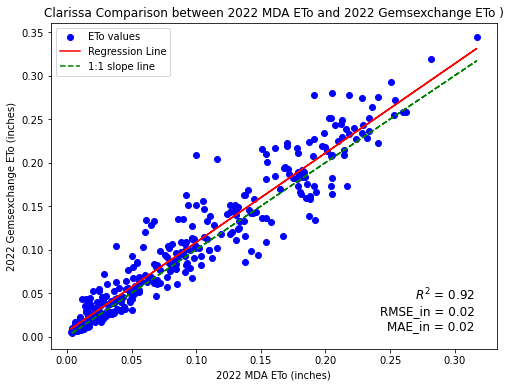

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming df_Becker and df are your DataFrames containing observed MDA ETr and observed Gemsexchange ETr respectively

# Observed MDA ETo
mda_eto_Clarissa2022 = df_ClarissaMDA_2022['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETo
gems_weatherbit_etoClarissa2022 = df_GEMS_Clarissa2022['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Clarissa2022, gems_weatherbit_etoClarissa2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoClarissa2022, model.predict(mda_eto_Clarissa2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoClarissa2022, model.predict(mda_eto_Clarissa2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoClarissa2022, model.predict(mda_eto_Clarissa2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Clarissa2022, gems_weatherbit_etoClarissa2022, color='blue', label='ETo values')
plt.plot(mda_eto_Clarissa2022, slope * mda_eto_Clarissa2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Clarissa2022, mda_eto_Clarissa2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETo (inches)')
plt.ylabel('2022 Gemsexchange ETo (inches)')
plt.title('Clarissa Comparison between 2022 MDA ETo and 2022 Gemsexchange ETo )')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()

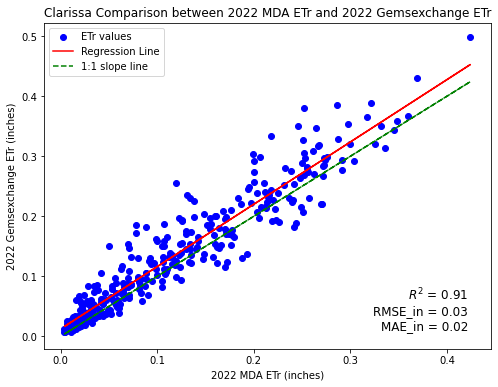

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Observed MDA ETr
mda_etr_Clarissa2022 = df_ClarissaMDA_2022['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETo
gems_weatherbit_etrClarissa2022 = df_GEMS_Clarissa2022['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Clarissa2022, gems_weatherbit_etrClarissa2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrClarissa2022, model.predict(mda_etr_Clarissa2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrClarissa2022, model.predict(mda_etr_Clarissa2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrClarissa2022, model.predict(mda_etr_Clarissa2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Clarissa2022, gems_weatherbit_etrClarissa2022, color='blue', label='ETr values')
plt.plot(mda_etr_Clarissa2022, slope * mda_etr_Clarissa2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Clarissa2022, mda_etr_Clarissa2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETr (inches)')
plt.ylabel('2022 Gemsexchange ETr (inches)')
plt.title('Clarissa Comparison between 2022 MDA ETr and 2022 Gemsexchange ETr')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


### Comparing Clarissa ETo and ETr 2023

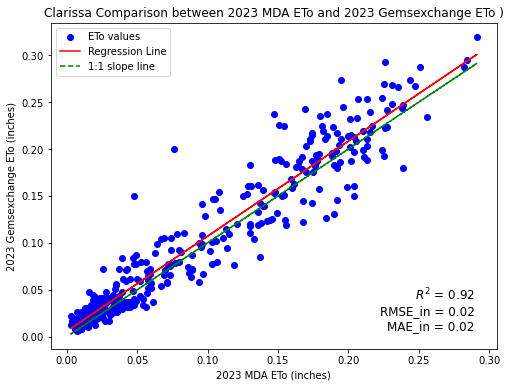

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assuming df_Becker and df are your DataFrames containing observed MDA ETr and observed Gemsexchange ETr respectively

# Observed MDA ETo
mda_eto_Clarissa2023 = df_ClarissaMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETo
gems_weatherbit_etoClarissa2023 = df_GEMS_Clarissa2023['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Clarissa2023, gems_weatherbit_etoClarissa2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoClarissa2023, model.predict(mda_eto_Clarissa2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoClarissa2023, model.predict(mda_eto_Clarissa2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoClarissa2023, model.predict(mda_eto_Clarissa2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Clarissa2023, gems_weatherbit_etoClarissa2023, color='blue', label='ETo values')
plt.plot(mda_eto_Clarissa2023, slope * mda_eto_Clarissa2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Clarissa2023, mda_eto_Clarissa2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('Clarissa Comparison between 2023 MDA ETo and 2023 Gemsexchange ETo )')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


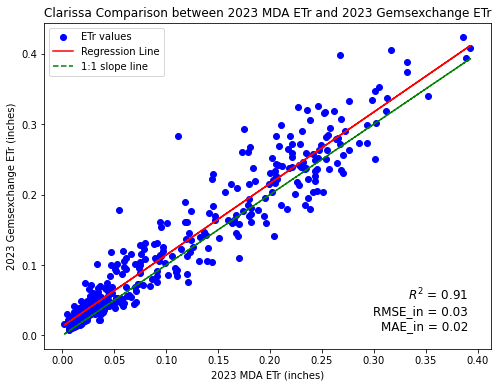

In [50]:
# Observed MDA ETr
mda_etr_Clarissa2023 = df_ClarissaMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrClarissa2023 = df_GEMS_Clarissa2023['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Clarissa2023, gems_weatherbit_etrClarissa2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrClarissa2023, model.predict(mda_etr_Clarissa2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrClarissa2023, model.predict(mda_etr_Clarissa2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrClarissa2023, model.predict(mda_etr_Clarissa2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Clarissa2023, gems_weatherbit_etrClarissa2023, color='blue', label='ETr values')
plt.plot(mda_etr_Clarissa2023, slope * mda_etr_Clarissa2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Clarissa2023, mda_etr_Clarissa2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('Clarissa Comparison between 2023 MDA ETr and 2023 Gemsexchange ETr')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


###  Comparing Hubbard ETo and ETr 2022 and 2023

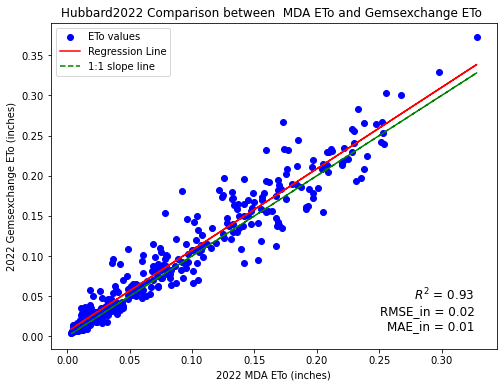

In [51]:
# Observed MDA ETo
mda_eto_Hubbard2022 = df_HubbardMDA_2022['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoHubbard2022 = df_GEMS_Hubbard2022['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Hubbard2022, gems_weatherbit_etoHubbard2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoHubbard2022, model.predict(mda_eto_Hubbard2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoHubbard2022, model.predict(mda_eto_Hubbard2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoHubbard2022, model.predict(mda_eto_Hubbard2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Hubbard2022, gems_weatherbit_etoHubbard2022, color='blue', label='ETo values')
plt.plot(mda_eto_Hubbard2022, slope * mda_eto_Hubbard2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Hubbard2022, mda_eto_Hubbard2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETo (inches)')
plt.ylabel('2022 Gemsexchange ETo (inches)')
plt.title('Hubbard2022 Comparison between  MDA ETo and Gemsexchange ETo ')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


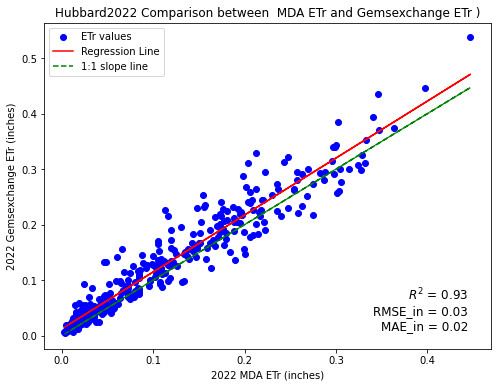

In [52]:
# Observed MDA ETr
mda_etr_Hubbard2022 = df_HubbardMDA_2022['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrHubbard2022 = df_GEMS_Hubbard2022['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Hubbard2022, gems_weatherbit_etrHubbard2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrHubbard2022, model.predict(mda_etr_Hubbard2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrHubbard2022, model.predict(mda_etr_Hubbard2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrHubbard2022, model.predict(mda_etr_Hubbard2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Hubbard2022, gems_weatherbit_etrHubbard2022, color='blue', label='ETr values')
plt.plot(mda_etr_Hubbard2022, slope * mda_etr_Hubbard2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Hubbard2022, mda_etr_Hubbard2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETr (inches)')
plt.ylabel('2022 Gemsexchange ETr (inches)')
plt.title('Hubbard2022 Comparison between  MDA ETr and Gemsexchange ETr )')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


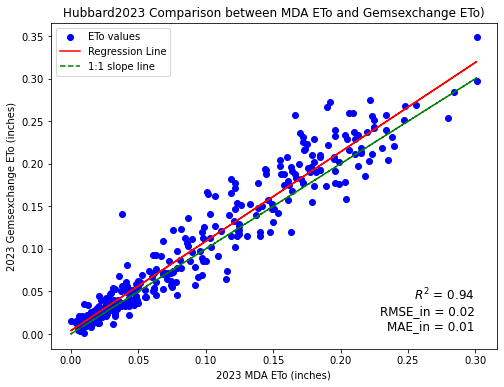

In [53]:
# Observed MDA ETo
mda_eto_Hubbard2023 = df_HubbardMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoHubbard2023 = df_GEMS_Hubbard2023['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Hubbard2023, gems_weatherbit_etoHubbard2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoHubbard2023, model.predict(mda_eto_Hubbard2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoHubbard2023, model.predict(mda_eto_Hubbard2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoHubbard2023, model.predict(mda_eto_Hubbard2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Hubbard2023, gems_weatherbit_etoHubbard2023, color='blue', label='ETo values')
plt.plot(mda_eto_Hubbard2023, slope * mda_eto_Hubbard2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Hubbard2023, mda_eto_Hubbard2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('Hubbard2023 Comparison between MDA ETo and Gemsexchange ETo)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


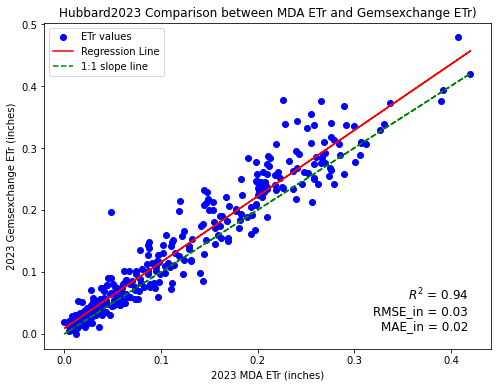

In [54]:
# Observed MDA ETr
mda_etr_Hubbard2023 = df_HubbardMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrHubbard2023 = df_GEMS_Hubbard2023['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Hubbard2023, gems_weatherbit_etrHubbard2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrHubbard2023, model.predict(mda_etr_Hubbard2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrHubbard2023, model.predict(mda_etr_Hubbard2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrHubbard2023, model.predict(mda_etr_Hubbard2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Hubbard2023, gems_weatherbit_etrHubbard2023, color='blue', label='ETr values')
plt.plot(mda_etr_Hubbard2023, slope * mda_etr_Hubbard2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Hubbard2023, mda_etr_Hubbard2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('Hubbard2023 Comparison between MDA ETr and Gemsexchange ETr)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


### Comparing LittleFalls ETo and ETr 2022 and 2023

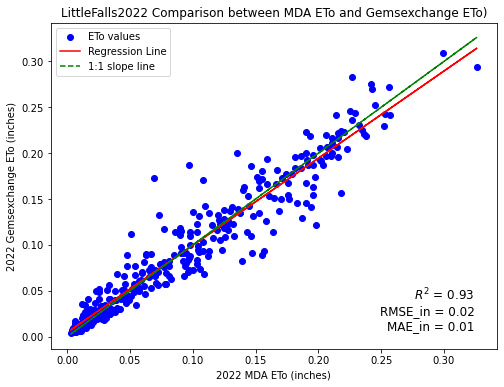

In [55]:
# Observed MDA ETo
mda_eto_LittleFalls2022 = df_LittleFallsMDA_2022['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoLittleFalls2022 = df_GEMS_LittleFalls2022['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_LittleFalls2022, gems_weatherbit_etoLittleFalls2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoLittleFalls2022, model.predict(mda_eto_LittleFalls2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoLittleFalls2022, model.predict(mda_eto_LittleFalls2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoLittleFalls2022, model.predict(mda_eto_LittleFalls2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_LittleFalls2022, gems_weatherbit_etoLittleFalls2022, color='blue', label='ETo values')
plt.plot(mda_eto_LittleFalls2022, slope * mda_eto_LittleFalls2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_LittleFalls2022, mda_eto_LittleFalls2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETo (inches)')
plt.ylabel('2022 Gemsexchange ETo (inches)')
plt.title('LittleFalls2022 Comparison between MDA ETo and Gemsexchange ETo)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


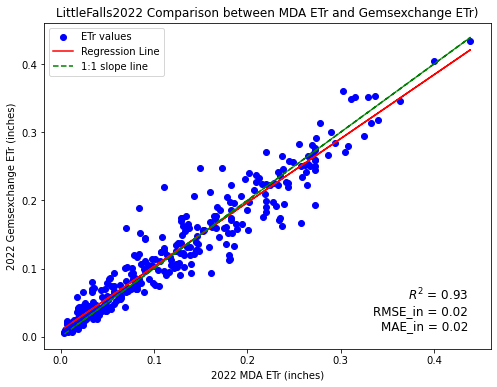

In [56]:
# Observed MDA ETr
mda_etr_LittleFalls2022 = df_LittleFallsMDA_2022['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrLittleFalls2022 = df_GEMS_LittleFalls2022['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_LittleFalls2022, gems_weatherbit_etrLittleFalls2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrLittleFalls2022, model.predict(mda_etr_LittleFalls2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrLittleFalls2022, model.predict(mda_etr_LittleFalls2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrLittleFalls2022, model.predict(mda_etr_LittleFalls2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_LittleFalls2022, gems_weatherbit_etrLittleFalls2022, color='blue', label='ETr values')
plt.plot(mda_etr_LittleFalls2022, slope * mda_etr_LittleFalls2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_LittleFalls2022, mda_etr_LittleFalls2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETr (inches)')
plt.ylabel('2022 Gemsexchange ETr (inches)')
plt.title('LittleFalls2022 Comparison between MDA ETr and Gemsexchange ETr)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


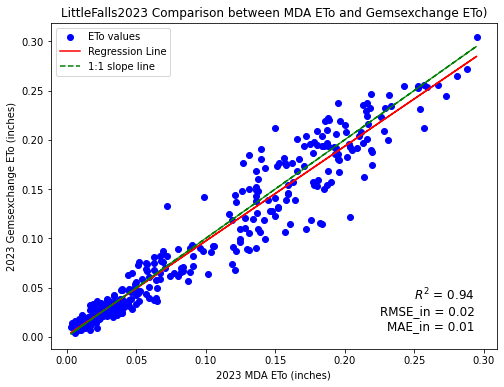

In [57]:
# Observed MDA ETo
mda_eto_LittleFalls2023 = df_LittleFallsMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoLittleFalls2023 = df_GEMS_LittleFalls2023['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_LittleFalls2023, gems_weatherbit_etoLittleFalls2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoLittleFalls2023, model.predict(mda_eto_LittleFalls2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoLittleFalls2023, model.predict(mda_eto_LittleFalls2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoLittleFalls2023, model.predict(mda_eto_LittleFalls2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_LittleFalls2023, gems_weatherbit_etoLittleFalls2023, color='blue', label='ETo values')
plt.plot(mda_eto_LittleFalls2023, slope * mda_eto_LittleFalls2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_LittleFalls2023, mda_eto_LittleFalls2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('LittleFalls2023 Comparison between MDA ETo and Gemsexchange ETo)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


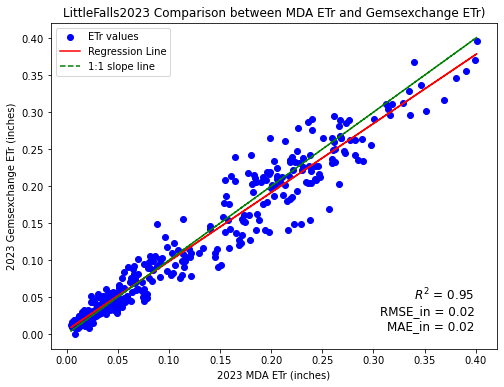

In [58]:
# Observed MDA ETr
mda_etr_LittleFalls2023 = df_LittleFallsMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrLittleFalls2023 = df_GEMS_LittleFalls2023['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_LittleFalls2023, gems_weatherbit_etrLittleFalls2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrLittleFalls2023, model.predict(mda_etr_LittleFalls2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrLittleFalls2023, model.predict(mda_etr_LittleFalls2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrLittleFalls2023, model.predict(mda_etr_LittleFalls2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_LittleFalls2023, gems_weatherbit_etrLittleFalls2023, color='blue', label='ETr values')
plt.plot(mda_etr_LittleFalls2023, slope * mda_etr_LittleFalls2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_LittleFalls2023, mda_etr_LittleFalls2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('LittleFalls2023 Comparison between MDA ETr and Gemsexchange ETr)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()

### Comparing MDA data with Gridded GEMS weatherbit data ParkersPrairie (2022/2023)

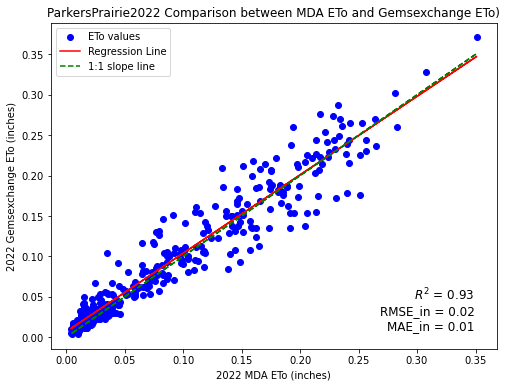

In [59]:
# Observed MDA ETo
mda_eto_ParkersPrairie2022 = df_ParkersPrairieMDA_2022['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoParkersPrairie2022 = df_GEMS_ParkersPrairie2022['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_ParkersPrairie2022, gems_weatherbit_etoParkersPrairie2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoParkersPrairie2022, model.predict(mda_eto_ParkersPrairie2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoParkersPrairie2022, model.predict(mda_eto_ParkersPrairie2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoParkersPrairie2022, model.predict(mda_eto_ParkersPrairie2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_ParkersPrairie2022, gems_weatherbit_etoParkersPrairie2022, color='blue', label='ETo values')
plt.plot(mda_eto_ParkersPrairie2022, slope * mda_eto_ParkersPrairie2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_ParkersPrairie2022, mda_eto_ParkersPrairie2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETo (inches)')
plt.ylabel('2022 Gemsexchange ETo (inches)')
plt.title('ParkersPrairie2022 Comparison between MDA ETo and Gemsexchange ETo)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


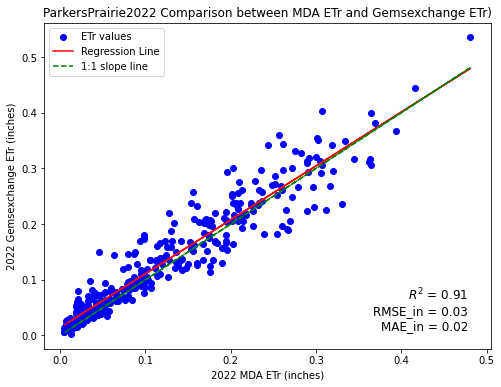

In [60]:
# Observed MDA ETr
mda_etr_ParkersPrairie2022 = df_ParkersPrairieMDA_2022['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrParkersPrairie2022 = df_GEMS_ParkersPrairie2022['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_ParkersPrairie2022, gems_weatherbit_etrParkersPrairie2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrParkersPrairie2022, model.predict(mda_etr_ParkersPrairie2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrParkersPrairie2022, model.predict(mda_etr_ParkersPrairie2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrParkersPrairie2022, model.predict(mda_etr_ParkersPrairie2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_ParkersPrairie2022, gems_weatherbit_etrParkersPrairie2022, color='blue', label='ETr values')
plt.plot(mda_etr_ParkersPrairie2022, slope * mda_etr_ParkersPrairie2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_ParkersPrairie2022, mda_etr_ParkersPrairie2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETr (inches)')
plt.ylabel('2022 Gemsexchange ETr (inches)')
plt.title('ParkersPrairie2022 Comparison between MDA ETr and Gemsexchange ETr)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


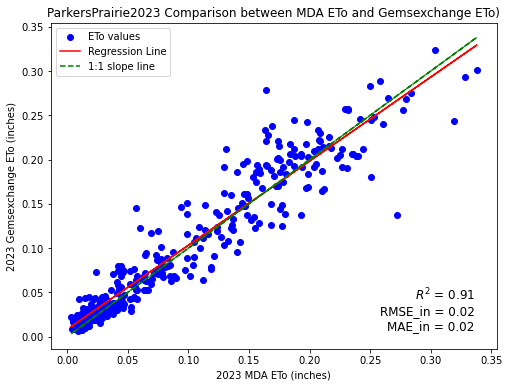

In [61]:
# Observed MDA ETo
mda_eto_ParkersPrairie2023 = df_ParkersPrairieMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoParkersPrairie2023 = df_GEMS_ParkersPrairie2023['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_ParkersPrairie2023, gems_weatherbit_etoParkersPrairie2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoParkersPrairie2023, model.predict(mda_eto_ParkersPrairie2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoParkersPrairie2023, model.predict(mda_eto_ParkersPrairie2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoParkersPrairie2023, model.predict(mda_eto_ParkersPrairie2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_ParkersPrairie2023, gems_weatherbit_etoParkersPrairie2023, color='blue', label='ETo values')
plt.plot(mda_eto_ParkersPrairie2023, slope * mda_eto_ParkersPrairie2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_ParkersPrairie2023, mda_eto_ParkersPrairie2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('ParkersPrairie2023 Comparison between MDA ETo and Gemsexchange ETo)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


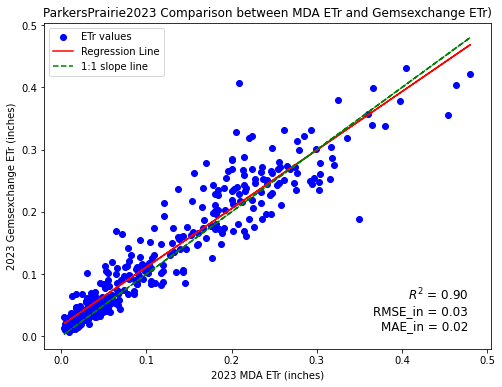

In [62]:
# Observed MDA ETr
mda_etr_ParkersPrairie2023 = df_ParkersPrairieMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrParkersPrairie2023 = df_GEMS_ParkersPrairie2023['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_ParkersPrairie2023, gems_weatherbit_etrParkersPrairie2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrParkersPrairie2023, model.predict(mda_etr_ParkersPrairie2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrParkersPrairie2023, model.predict(mda_etr_ParkersPrairie2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrParkersPrairie2023, model.predict(mda_etr_ParkersPrairie2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_ParkersPrairie2023, gems_weatherbit_etrParkersPrairie2023, color='blue', label='ETr values')
plt.plot(mda_etr_ParkersPrairie2023, slope * mda_etr_ParkersPrairie2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_ParkersPrairie2023, mda_etr_ParkersPrairie2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('ParkersPrairie2023 Comparison between MDA ETr and Gemsexchange ETr)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


### Comparing MDA data with Gridded GEMS weatherbit data Perham (2022/2023)

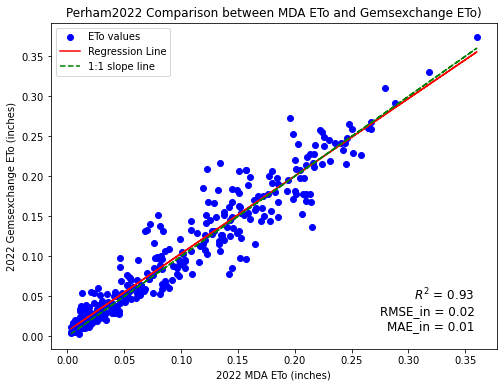

In [63]:
# Observed MDA ETo
mda_eto_Perham2022 = df_PerhamMDA_2022['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoPerham2022 = df_GEMS_Perham2022['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Perham2022, gems_weatherbit_etoPerham2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoPerham2022, model.predict(mda_eto_Perham2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoPerham2022, model.predict(mda_eto_Perham2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoPerham2022, model.predict(mda_eto_Perham2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Perham2022, gems_weatherbit_etoPerham2022, color='blue', label='ETo values')
plt.plot(mda_eto_Perham2022, slope * mda_eto_Perham2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Perham2022, mda_eto_Perham2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETo (inches)')
plt.ylabel('2022 Gemsexchange ETo (inches)')
plt.title('Perham2022 Comparison between MDA ETo and Gemsexchange ETo)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


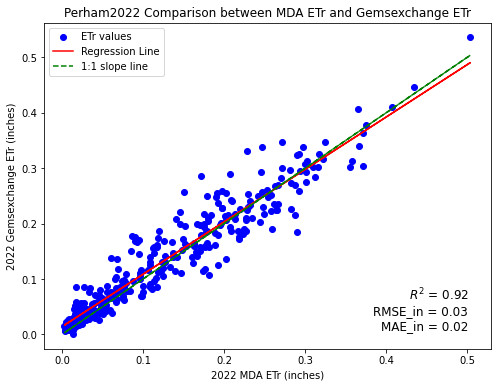

In [64]:
# Observed MDA ETr
mda_etr_Perham2022 = df_PerhamMDA_2022['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrPerham2022 = df_GEMS_Perham2022['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Perham2022, gems_weatherbit_etrPerham2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrPerham2022, model.predict(mda_etr_Perham2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrPerham2022, model.predict(mda_etr_Perham2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrPerham2022, model.predict(mda_etr_Perham2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Perham2022, gems_weatherbit_etrPerham2022, color='blue', label='ETr values')
plt.plot(mda_etr_Perham2022, slope * mda_etr_Perham2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Perham2022, mda_etr_Perham2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETr (inches)')
plt.ylabel('2022 Gemsexchange ETr (inches)')
plt.title('Perham2022 Comparison between MDA ETr and Gemsexchange ETr')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


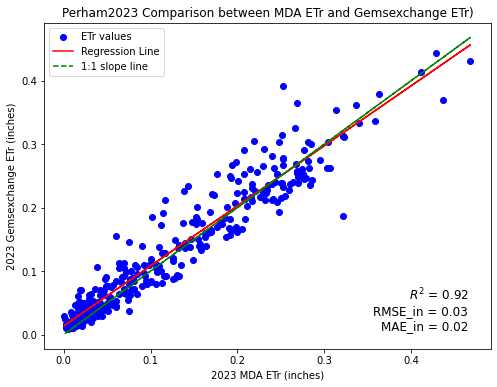

In [65]:
# Observed MDA ETr
mda_etr_Perham2023 = df_PerhamMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrPerham2023 = df_GEMS_Perham2023['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Perham2023, gems_weatherbit_etrPerham2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrPerham2023, model.predict(mda_etr_Perham2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrPerham2023, model.predict(mda_etr_Perham2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrPerham2023, model.predict(mda_etr_Perham2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Perham2023, gems_weatherbit_etrPerham2023, color='blue', label='ETr values')
plt.plot(mda_etr_Perham2023, slope * mda_etr_Perham2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Perham2023, mda_etr_Perham2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('Perham2023 Comparison between MDA ETr and Gemsexchange ETr)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


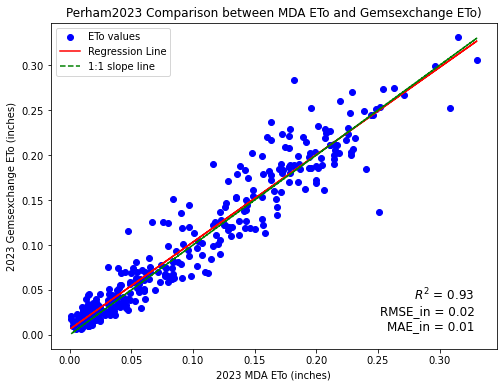

In [66]:
# Observed MDA ETo
mda_eto_Perham2023 = df_PerhamMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoPerham2023 = df_GEMS_Perham2023['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Perham2023, gems_weatherbit_etoPerham2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoPerham2023, model.predict(mda_eto_Perham2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoPerham2023, model.predict(mda_eto_Perham2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoPerham2023, model.predict(mda_eto_Perham2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Perham2023, gems_weatherbit_etoPerham2023, color='blue', label='ETo values')
plt.plot(mda_eto_Perham2023, slope * mda_eto_Perham2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Perham2023, mda_eto_Perham2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('Perham2023 Comparison between MDA ETo and Gemsexchange ETo)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


### Comparing PinePoint MDA with Gridded GEMS 

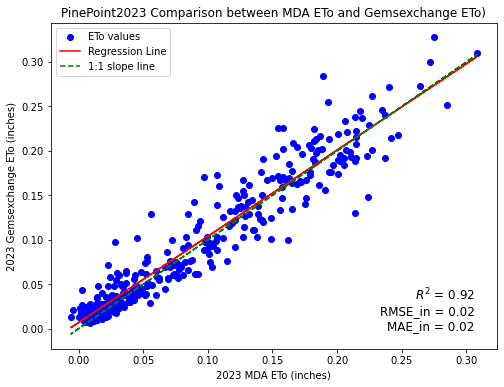

In [67]:
# Observed MDA ETo
mda_eto_PinePoint2023 = df_PinePointMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoPinePoint2023 = df_GEMS_PinePoint2023['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_PinePoint2023, gems_weatherbit_etoPinePoint2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoPinePoint2023, model.predict(mda_eto_PinePoint2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoPinePoint2023, model.predict(mda_eto_PinePoint2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoPinePoint2023, model.predict(mda_eto_PinePoint2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_PinePoint2023, gems_weatherbit_etoPinePoint2023, color='blue', label='ETo values')
plt.plot(mda_eto_PinePoint2023, slope * mda_eto_PinePoint2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_PinePoint2023, mda_eto_PinePoint2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('PinePoint2023 Comparison between MDA ETo and Gemsexchange ETo)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


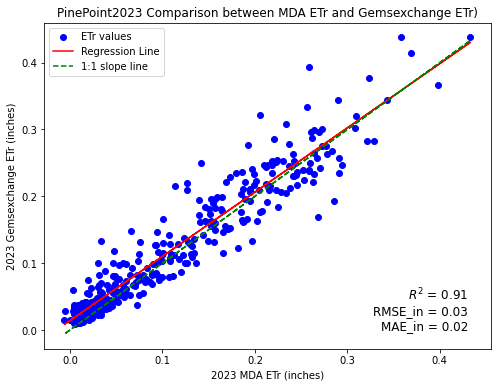

In [68]:
# Observed MDA ETr
mda_etr_PinePoint2023 = df_PinePointMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrPinePoint2023 = df_GEMS_PinePoint2023['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_PinePoint2023, gems_weatherbit_etrPinePoint2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrPinePoint2023, model.predict(mda_etr_PinePoint2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrPinePoint2023, model.predict(mda_etr_PinePoint2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrPinePoint2023, model.predict(mda_etr_PinePoint2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_PinePoint2023, gems_weatherbit_etrPinePoint2023, color='blue', label='ETr values')
plt.plot(mda_etr_PinePoint2023, slope * mda_etr_PinePoint2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_PinePoint2023, mda_etr_PinePoint2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('PinePoint2023 Comparison between MDA ETr and Gemsexchange ETr)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


### Rice 2022 and 2023 Gridded GEMS vs MDA

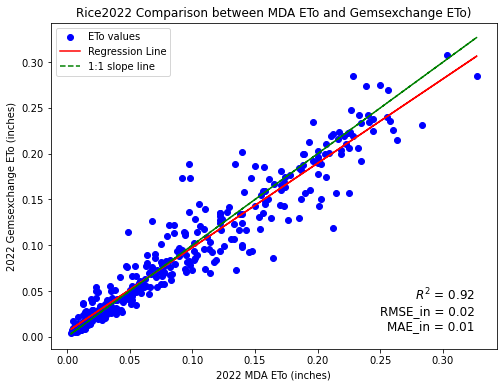

In [69]:
# Observed MDA ETo
mda_eto_Rice2022 = df_RiceMDA_2022['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoRice2022 = df_GEMS_Rice2022['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Rice2022, gems_weatherbit_etoRice2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoRice2022, model.predict(mda_eto_Rice2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoRice2022, model.predict(mda_eto_Rice2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoRice2022, model.predict(mda_eto_Rice2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Rice2022, gems_weatherbit_etoRice2022, color='blue', label='ETo values')
plt.plot(mda_eto_Rice2022, slope * mda_eto_Rice2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Rice2022, mda_eto_Rice2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETo (inches)')
plt.ylabel('2022 Gemsexchange ETo (inches)')
plt.title('Rice2022 Comparison between MDA ETo and Gemsexchange ETo)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


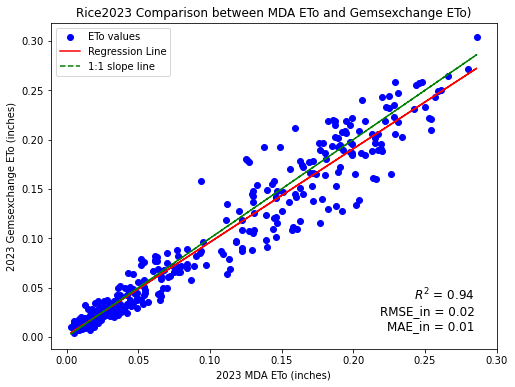

In [70]:
# Observed MDA ETo
mda_eto_Rice2023 = df_RiceMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoRice2023 = df_GEMS_Rice2023['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Rice2023, gems_weatherbit_etoRice2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoRice2023, model.predict(mda_eto_Rice2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoRice2023, model.predict(mda_eto_Rice2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoRice2023, model.predict(mda_eto_Rice2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Rice2023, gems_weatherbit_etoRice2023, color='blue', label='ETo values')
plt.plot(mda_eto_Rice2023, slope * mda_eto_Rice2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Rice2023, mda_eto_Rice2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('Rice2023 Comparison between MDA ETo and Gemsexchange ETo)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


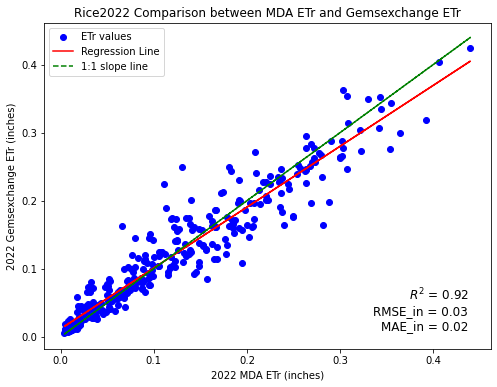

In [71]:
# Observed MDA ETr
mda_etr_Rice2022 = df_RiceMDA_2022['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrRice2022 = df_GEMS_Rice2022['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Rice2022, gems_weatherbit_etrRice2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrRice2022, model.predict(mda_etr_Rice2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrRice2022, model.predict(mda_etr_Rice2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrRice2022, model.predict(mda_etr_Rice2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Rice2022, gems_weatherbit_etrRice2022, color='blue', label='ETr values')
plt.plot(mda_etr_Rice2022, slope * mda_etr_Rice2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Rice2022, mda_etr_Rice2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETr (inches)')
plt.ylabel('2022 Gemsexchange ETr (inches)')
plt.title('Rice2022 Comparison between MDA ETr and Gemsexchange ETr')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


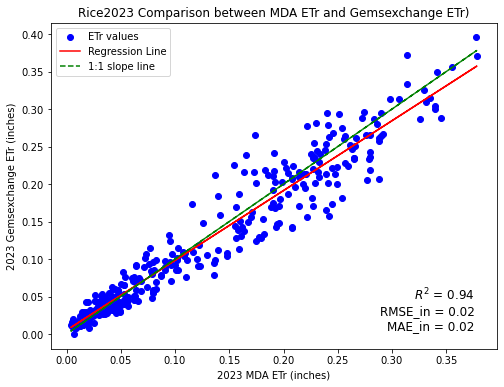

In [72]:
# Observed MDA ETr
mda_etr_Rice2023 = df_RiceMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrRice2023 = df_GEMS_Rice2023['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Rice2023, gems_weatherbit_etrRice2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrRice2023, model.predict(mda_etr_Rice2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrRice2023, model.predict(mda_etr_Rice2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrRice2023, model.predict(mda_etr_Rice2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Rice2023, gems_weatherbit_etrRice2023, color='blue', label='ETr values')
plt.plot(mda_etr_Rice2023, slope * mda_etr_Rice2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Rice2023, mda_etr_Rice2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('Rice2023 Comparison between MDA ETr and Gemsexchange ETr)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


### Comparing Staples datasets Gridded VS MDA 2022 and 2023

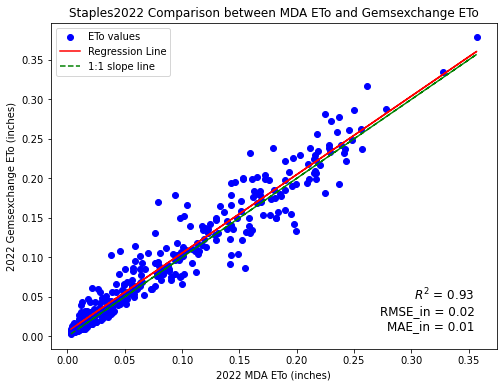

In [73]:
# Observed MDA ETo
mda_eto_Staples2022 = df_StaplesMDA_2022['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoStaples2022 = df_GEMS_Staples2022['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Staples2022, gems_weatherbit_etoStaples2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoStaples2022, model.predict(mda_eto_Staples2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoStaples2022, model.predict(mda_eto_Staples2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoStaples2022, model.predict(mda_eto_Staples2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Staples2022, gems_weatherbit_etoStaples2022, color='blue', label='ETo values')
plt.plot(mda_eto_Staples2022, slope * mda_eto_Staples2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Staples2022, mda_eto_Staples2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETo (inches)')
plt.ylabel('2022 Gemsexchange ETo (inches)')
plt.title('Staples2022 Comparison between MDA ETo and Gemsexchange ETo')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


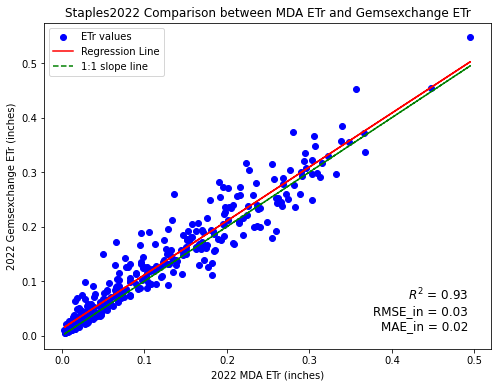

In [74]:
# Observed MDA ETr
mda_etr_Staples2022 = df_StaplesMDA_2022['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrStaples2022 = df_GEMS_Staples2022['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Staples2022, gems_weatherbit_etrStaples2022)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrStaples2022, model.predict(mda_etr_Staples2022))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrStaples2022, model.predict(mda_etr_Staples2022))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrStaples2022, model.predict(mda_etr_Staples2022)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Staples2022, gems_weatherbit_etrStaples2022, color='blue', label='ETr values')
plt.plot(mda_etr_Staples2022, slope * mda_etr_Staples2022 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Staples2022, mda_etr_Staples2022, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2022 MDA ETr (inches)')
plt.ylabel('2022 Gemsexchange ETr (inches)')
plt.title('Staples2022 Comparison between MDA ETr and Gemsexchange ETr')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


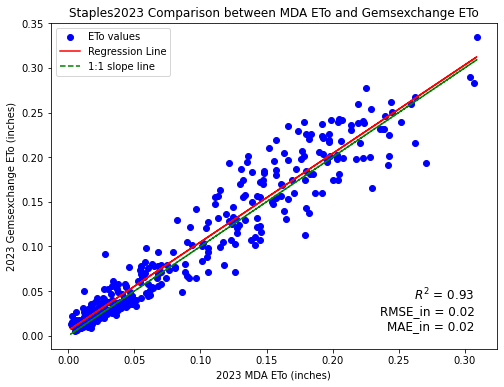

In [75]:
# Observed MDA ETo
mda_eto_Staples2023 = df_StaplesMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoStaples2023 = df_GEMS_Staples2023['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Staples2023, gems_weatherbit_etoStaples2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoStaples2023, model.predict(mda_eto_Staples2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoStaples2023, model.predict(mda_eto_Staples2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoStaples2023, model.predict(mda_eto_Staples2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Staples2023, gems_weatherbit_etoStaples2023, color='blue', label='ETo values')
plt.plot(mda_eto_Staples2023, slope * mda_eto_Staples2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Staples2023, mda_eto_Staples2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('Staples2023 Comparison between MDA ETo and Gemsexchange ETo')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


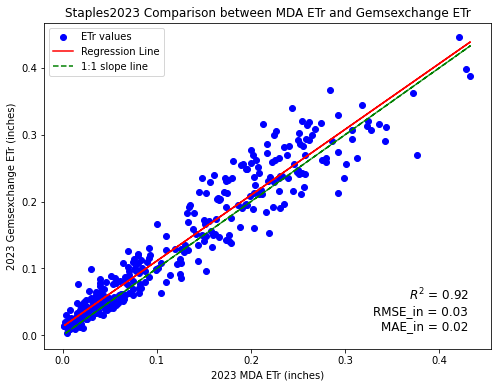

In [76]:
# Observed MDA ETr
mda_etr_Staples2023 = df_StaplesMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrStaples2023 = df_GEMS_Staples2023['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Staples2023, gems_weatherbit_etrStaples2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrStaples2023, model.predict(mda_etr_Staples2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrStaples2023, model.predict(mda_etr_Staples2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrStaples2023, model.predict(mda_etr_Staples2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Staples2023, gems_weatherbit_etrStaples2023, color='blue', label='ETr values')
plt.plot(mda_etr_Staples2023, slope * mda_etr_Staples2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Staples2023, mda_etr_Staples2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('Staples2023 Comparison between MDA ETr and Gemsexchange ETr')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


### Wadena 2022 and 2023 Gridded GEMS data vs MDA data

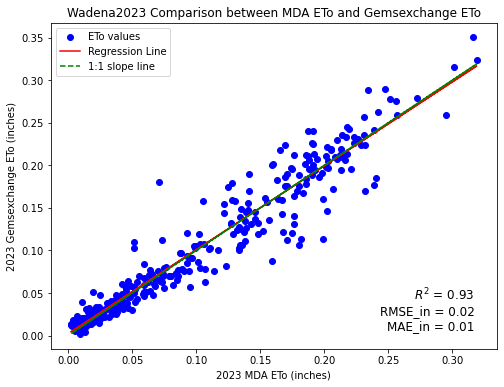

In [77]:
# Observed MDA ETo
mda_eto_Wadena2023 = df_WadenaMDA_2023['ETos_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etoWadena2023 = df_GEMS_Wadena2023['ETo (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_eto_Wadena2023, gems_weatherbit_etoWadena2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etoWadena2023, model.predict(mda_eto_Wadena2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etoWadena2023, model.predict(mda_eto_Wadena2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etoWadena2023, model.predict(mda_eto_Wadena2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_eto_Wadena2023, gems_weatherbit_etoWadena2023, color='blue', label='ETo values')
plt.plot(mda_eto_Wadena2023, slope * mda_eto_Wadena2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_eto_Wadena2023, mda_eto_Wadena2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETo (inches)')
plt.ylabel('2023 Gemsexchange ETo (inches)')
plt.title('Wadena2023 Comparison between MDA ETo and Gemsexchange ETo')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()


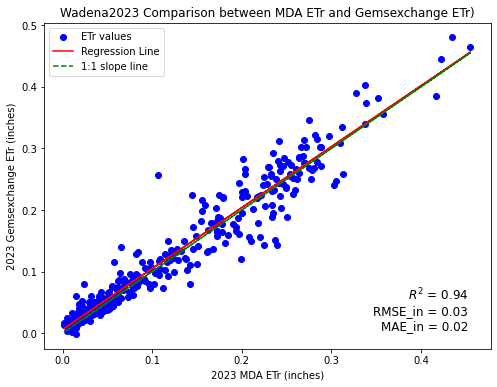

In [78]:
# Observed MDA ETr
mda_etr_Wadena2023 = df_WadenaMDA_2023['ETrs_daily_in'].values.reshape(-1, 1)
# Observed Gemsexchange ETr
gems_weatherbit_etrWadena2023 = df_GEMS_Wadena2023['ETr (in/day)'].values

# Fit linear regression model
model = LinearRegression()
model.fit(mda_etr_Wadena2023, gems_weatherbit_etrWadena2023)

# Get the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_

# Calculate R^2
r2 = r2_score(gems_weatherbit_etrWadena2023, model.predict(mda_etr_Wadena2023))

# Calculate MAE
mae = mean_absolute_error(gems_weatherbit_etrWadena2023, model.predict(mda_etr_Wadena2023))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(gems_weatherbit_etrWadena2023, model.predict(mda_etr_Wadena2023)))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(mda_etr_Wadena2023, gems_weatherbit_etrWadena2023, color='blue', label='ETr values')
plt.plot(mda_etr_Wadena2023, slope * mda_etr_Wadena2023 + intercept, color='red', label='Regression Line')
plt.plot(mda_etr_Wadena2023, mda_etr_Wadena2023, color='green', linestyle='--', label='1:1 slope line')
plt.xlabel('2023 MDA ETr (inches)')
plt.ylabel('2023 Gemsexchange ETr (inches)')
plt.title('Wadena2023 Comparison between MDA ETr and Gemsexchange ETr)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, '$R^2$ = {:.2f}\nRMSE_in = {:.2f}\nMAE_in = {:.2f}'.format(r2, rmse, mae),
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()

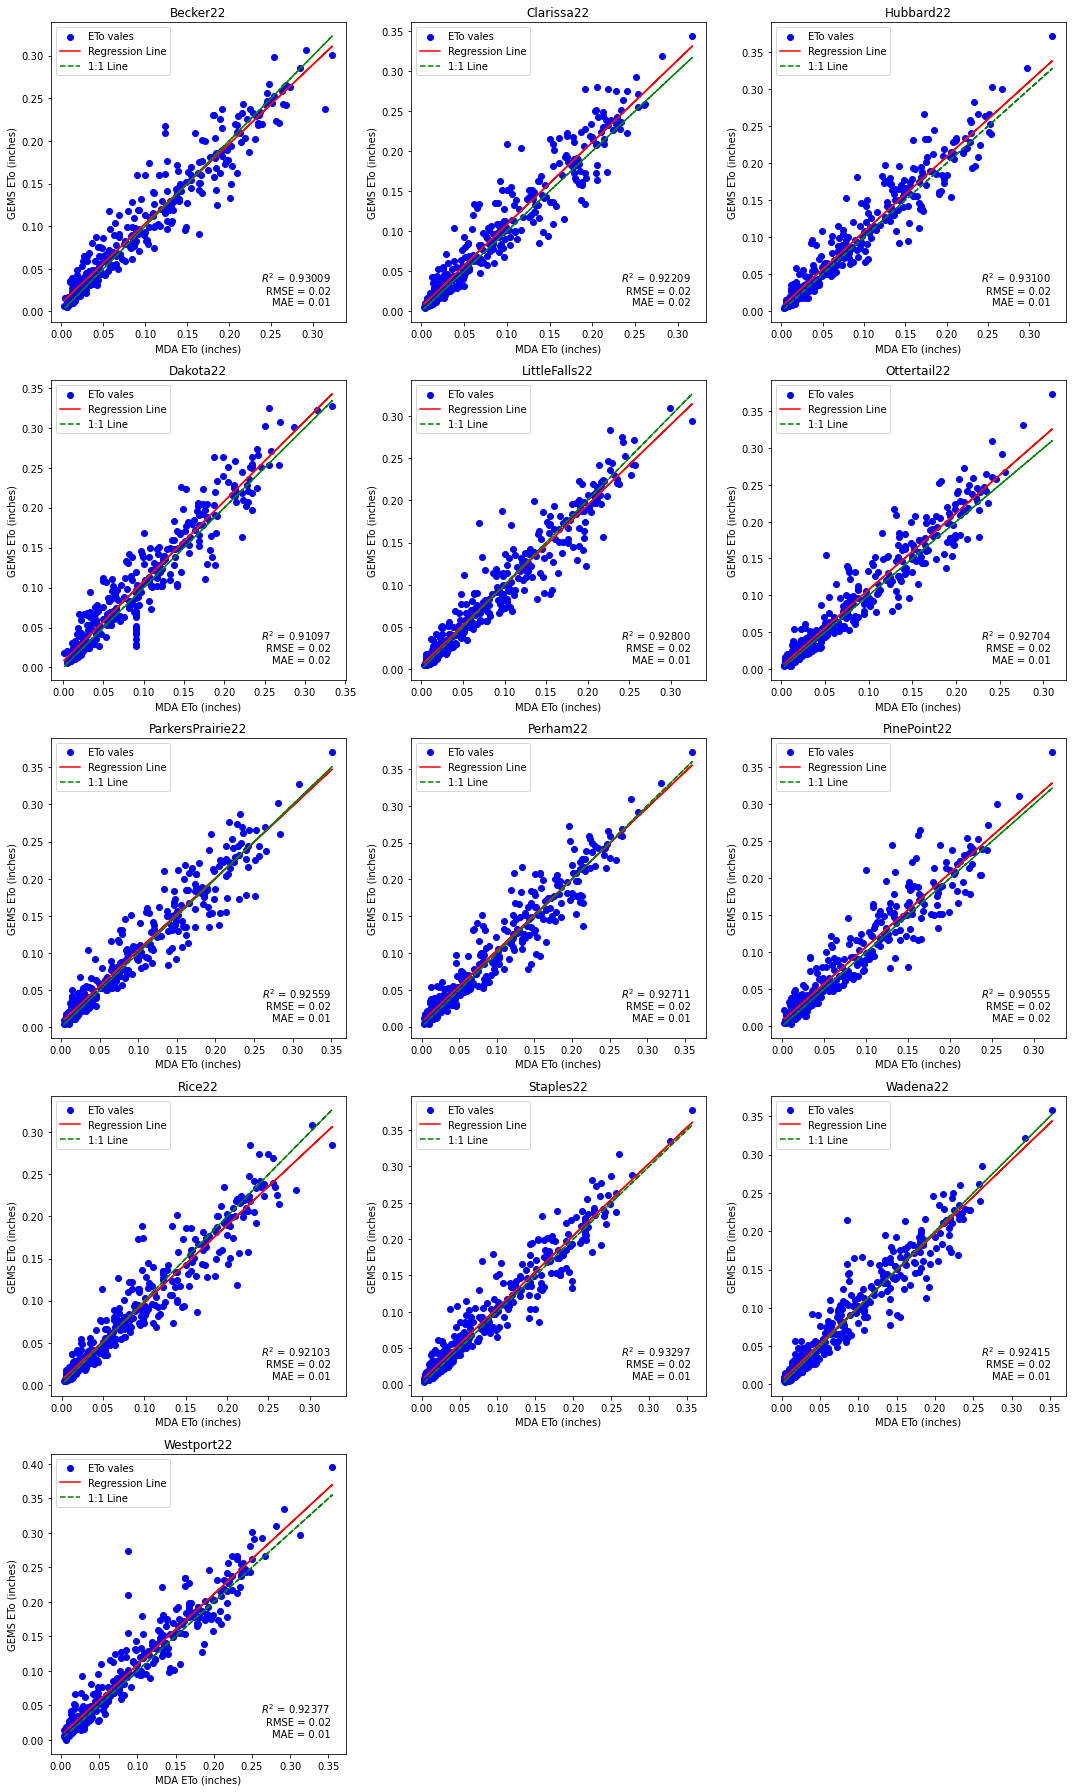

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Define the locations and corresponding dataframes
locations = [
    ("Becker22", df_BeckerMDA_2022, df_GEMS_Sherbourne2022),
    ("Clarissa22", df_ClarissaMDA_2022, df_GEMS_Clarissa2022),
    ("Hubbard22", df_HubbardMDA_2022, df_GEMS_Hubbard2022),
    ("Dakota22", df_HastingsMDA_2022, df_GEMS_Dakota2022),
    ("LittleFalls22", df_LittleFallsMDA_2022, df_GEMS_LittleFalls2022),
    ("Ottertail22", df_OtterTailMDA_2022, df_GEMS_OtterTail2022),
    ("ParkersPrairie22", df_ParkersPrairieMDA_2022, df_GEMS_ParkersPrairie2022),
    ("Perham22", df_PerhamMDA_2022, df_GEMS_Perham2022),
    ("PinePoint22", df_PinePointMDA_2022, df_GEMS_PinePoint2022),
    ("Rice22", df_RiceMDA_2022, df_GEMS_Rice2022),
    ("Staples22", df_StaplesMDA_2022, df_GEMS_Staples2022),
    ("Wadena22", df_WadenaMDA_2022, df_GEMS_Wadena2022),
    ("Westport22", df_WestportMDA_2022, df_GEMS_Douglas2022)
]

# Create subplots
num_plots = len(locations)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axs = axs.flatten()

for idx, (location_name, df_MDA, df_GEMS) in enumerate(locations):
    mda_eto = df_MDA['ETos_daily_in'].values.reshape(-1, 1)
    gems_eto = df_GEMS['ETo (in/day)'].values

    # Handling missing values
    imputer = SimpleImputer(strategy='mean')
    mda_eto = imputer.fit_transform(mda_eto)

    # Fit linear regression model
    model = LinearRegression()
    model.fit(mda_eto, gems_eto)

    # Calculate R^2, MAE, and RMSE
    r2 = r2_score(gems_eto, model.predict(mda_eto))
    mae = mean_absolute_error(gems_eto, model.predict(mda_eto))
    rmse = np.sqrt(mean_squared_error(gems_eto, model.predict(mda_eto)))

    # Plotting
    ax = axs[idx]
    ax.scatter(mda_eto, gems_eto, color='blue', label='ETo vales')
    ax.plot(mda_eto, model.predict(mda_eto), color='red', label='Regression Line')
    ax.plot(mda_eto, mda_eto, color='green', linestyle='--', label='1:1 Line')
    ax.set_xlabel('MDA ETo (inches)')
    ax.set_ylabel('GEMS ETo (inches)')
    ax.set_title(f'{location_name}')
    ax.legend()
    ax.grid(False)
    ax.text(0.95, 0.05, f'$R^2$ = {r2:.5f}\nRMSE = {rmse:.2f}\nMAE = {mae:.2f}',
            verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, fontsize=10)

# Hide any unused axes
for i in range(idx + 1, len(axs)):
    axs[i].set_visible(False)

plt.tight_layout()
plt.show()


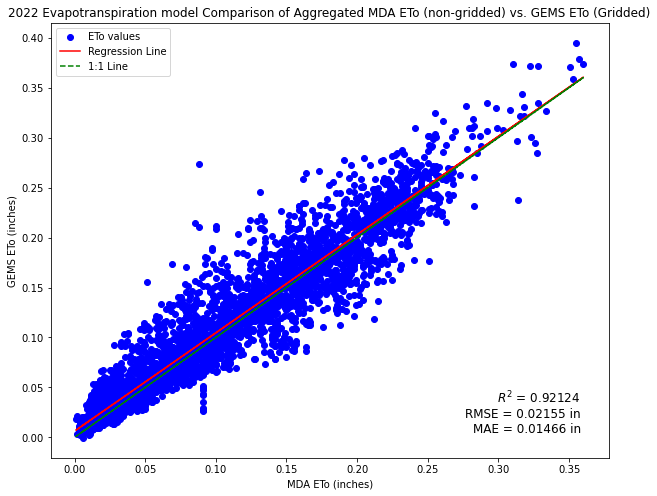

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr 
# Define the locations and corresponding dataframes
locations = [
    ("Becker22", df_BeckerMDA_2022, df_GEMS_Sherbourne2022),
    ("Clarissa22", df_ClarissaMDA_2022, df_GEMS_Clarissa2022),
    ("Hubbard22", df_HubbardMDA_2022, df_GEMS_Hubbard2022),
    ("Dakota22", df_HastingsMDA_2022, df_GEMS_Dakota2022),
    ("LittleFalls22", df_LittleFallsMDA_2022, df_GEMS_LittleFalls2022),
    ("Ottertail22", df_OtterTailMDA_2022, df_GEMS_OtterTail2022),
    ("ParkersPrairie22", df_ParkersPrairieMDA_2022, df_GEMS_ParkersPrairie2022),
    ("Perham22", df_PerhamMDA_2022, df_GEMS_Perham2022),
    ("PinePoint22", df_PinePointMDA_2022, df_GEMS_PinePoint2022),
    ("Rice22", df_RiceMDA_2022, df_GEMS_Rice2022),
    ("Staples22", df_StaplesMDA_2022, df_GEMS_Staples2022),
    ("Wadena22", df_WadenaMDA_2022, df_GEMS_Wadena2022),
    ("Westport22", df_WestportMDA_2022, df_GEMS_Douglas2022)
]

# Combine all data
all_mda_eto = np.array([])
all_gems_eto = np.array([])

for _, df_MDA, df_GEMS in locations:
    mda_eto = df_MDA['ETos_daily_in'].values
    gems_eto = df_GEMS['ETo (in/day)'].values

    # Handling missing values with imputation
    imputer = SimpleImputer(strategy='mean')
    mda_eto_imputed = imputer.fit_transform(mda_eto.reshape(-1, 1)).flatten()

    all_mda_eto = np.concatenate([all_mda_eto, mda_eto_imputed])
    all_gems_eto = np.concatenate([all_gems_eto, gems_eto])

# Fit linear regression model
model = LinearRegression()
model.fit(all_mda_eto.reshape(-1, 1), all_gems_eto)

# Calculate metrics
predictions = model.predict(all_mda_eto.reshape(-1, 1))
r2 = r2_score(all_gems_eto, predictions)
mae = mean_absolute_error(all_gems_eto, predictions)
rmse = np.sqrt(mean_squared_error(all_gems_eto, predictions))

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(all_mda_eto, all_gems_eto, color='blue', label='ETo values')
plt.plot(all_mda_eto, predictions, color='red', label='Regression Line')
plt.plot(all_mda_eto, all_mda_eto, color='green', linestyle='--', label='1:1 Line')
plt.xlabel('MDA ETo (inches)')
plt.ylabel('GEMS ETo (inches)')
plt.title('2022 Evapotranspiration model Comparison of Aggregated MDA ETo (non-gridded) vs. GEMS ETo (Gridded)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, f'$R^2$ = {r2:.5f}\nRMSE = {rmse:.5f} in\nMAE = {mae:.5f} in',
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()
# Calculate Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(all_mda_eto, all_gems_eto)
# Print Pearson correlation coefficient and p-value
#print("Pearson correlation coefficient:", pearson_corr)
# Print p-value with 10 decimal places
#print("P-value:", "{:.10f}".format(p_value))

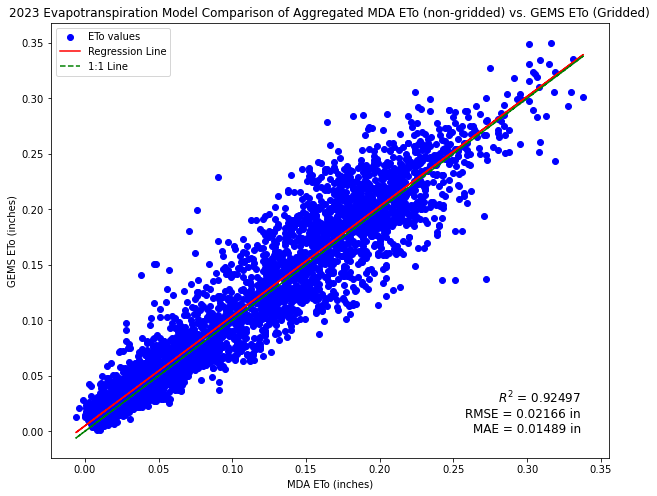

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Define the locations and corresponding dataframes for 2023
locations = [
    ("Becker23", df_BeckerMDA_2023, df_GEMS_Sherbourne2023),
    ("Clarissa23", df_ClarissaMDA_2023, df_GEMS_Clarissa2023),
    ("Hubbard23", df_HubbardMDA_2023, df_GEMS_Hubbard2023),
    ("Dakota23", df_HastingsMDA_2023, df_GEMS_Dakota2023),
    ("LittleFalls23", df_LittleFallsMDA_2023, df_GEMS_LittleFalls2023),
    ("Ottertail23", df_OtterTailMDA_2023, df_GEMS_OtterTail2023),
    ("ParkersPrairie23", df_ParkersPrairieMDA_2023, df_GEMS_ParkersPrairie2023),
    ("Perham23", df_PerhamMDA_2023, df_GEMS_Perham2023),
    ("PinePoint23", df_PinePointMDA_2023, df_GEMS_PinePoint2023),
    ("Rice23", df_RiceMDA_2023, df_GEMS_Rice2023),
    ("Staples23", df_StaplesMDA_2023, df_GEMS_Staples2023),
    ("Wadena23", df_WadenaMDA_2023, df_GEMS_Wadena2023),
    ("Westport23", df_WestportMDA_2023, df_GEMS_Douglas2023)
]

# Combine all data
all_mda_eto = np.array([])
all_gems_eto = np.array([])

for _, df_MDA, df_GEMS in locations:
    mda_eto = df_MDA['ETos_daily_in'].values
    gems_eto = df_GEMS['ETo (in/day)'].values

    # Handling missing values with imputation
    imputer = SimpleImputer(strategy='mean')
    mda_eto_imputed = imputer.fit_transform(mda_eto.reshape(-1, 1)).flatten()

    all_mda_eto = np.concatenate([all_mda_eto, mda_eto_imputed])
    all_gems_eto = np.concatenate([all_gems_eto, gems_eto])

# Fit linear regression model
model = LinearRegression()
model.fit(all_mda_eto.reshape(-1, 1), all_gems_eto)

# Calculate metrics
predictions = model.predict(all_mda_eto.reshape(-1, 1))
r2 = r2_score(all_gems_eto, predictions)
mae = mean_absolute_error(all_gems_eto, predictions)
rmse = np.sqrt(mean_squared_error(all_gems_eto, predictions))

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(all_mda_eto, all_gems_eto, color='blue', label='ETo values')
plt.plot(all_mda_eto, predictions, color='red', label='Regression Line')
plt.plot(all_mda_eto, all_mda_eto, color='green', linestyle='--', label='1:1 Line')
plt.xlabel('MDA ETo (inches)')
plt.ylabel('GEMS ETo (inches)')
plt.title('2023 Evapotranspiration Model Comparison of Aggregated MDA ETo (non-gridded) vs. GEMS ETo (Gridded)')
plt.legend()
plt.grid(False)
plt.text(0.95, 0.05, f'$R^2$ = {r2:.5f}\nRMSE = {rmse:.5f} in\nMAE = {mae:.5f} in',
         verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=12)
plt.show()
# Calculate Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(all_mda_eto, all_gems_eto)
# Print Pearson correlation coefficient and p-value
#print("Pearson correlation coefficient:", pearson_corr)
# Print p-value with 10 decimal places
#print("P-value:", "{:.10f}".format(p_value))